# Shortcut

to download interactions without running notebook go to:

https://drive.google.com/drive/folders/1QDJysd4CeW2U-IzwqOOgotS-msYwk8_z?usp=share_link

# Calculate communication

In [1]:
# libraries
library(community)
library(dplyr)
require(ggplot2)
require(gridExtra)
require(grid)
require(ComplexHeatmap)
require(dendsort)
require(igraph)
require(circlize)
require(R.utils)
require(data.table) #to read gz file
require(org.Hs.eg.db)
require(clusterProfiler)


Attache Paket: ‘dplyr’


Die folgenden Objekte sind maskiert von ‘package:stats’:

    filter, lag


Die folgenden Objekte sind maskiert von ‘package:base’:

    intersect, setdiff, setequal, union


Lade nötiges Paket: ggplot2

Lade nötiges Paket: gridExtra


Attache Paket: ‘gridExtra’


Das folgende Objekt ist maskiert ‘package:dplyr’:

    combine


Lade nötiges Paket: grid

Lade nötiges Paket: ComplexHeatmap

ComplexHeatmap version 2.14.0
Bioconductor page: http://bioconductor.org/packages/ComplexHeatmap/
Github page: https://github.com/jokergoo/ComplexHeatmap
Documentation: http://jokergoo.github.io/ComplexHeatmap-reference

If you use it in published research, please cite either one:
- Gu, Z. Complex Heatmap Visualization. iMeta 2022.
- Gu, Z. Complex heatmaps reveal patterns and correlations in multidimensional 
    genomic data. Bioinformatics 2016.


The new InteractiveComplexHeatmap package can directly export static 
complex heatmaps into an interactive Shiny app with zero 

In [2]:
# the path to the counts, cell annotation and sample annation file. In this case its our working dir same as
# the notebook
path_in <- paste0(getwd(),"/rdata")

print("path_in")
print(path_in)

[1] "path_in"
[1] "/work/project/ladcol_013/algo_ulc/rdata"


In [3]:
sessionInfo()

R version 4.2.3 (2023-03-15)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS/LAPACK: /home/fsalcher/miniconda3/envs/community_tutorial/lib/libopenblasp-r0.3.21.so

locale:
 [1] LC_CTYPE=de_AT.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=de_AT.UTF-8        LC_COLLATE=de_AT.UTF-8    
 [5] LC_MONETARY=de_AT.UTF-8    LC_MESSAGES=de_AT.UTF-8   
 [7] LC_PAPER=de_AT.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=de_AT.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    grid      stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] clusterProfiler_4.6.2 org.Hs.eg.db_3.16.0   AnnotationDbi_1.60.2 
 [4] IRanges_2.32.0        S4Vectors_0.36.2      Biobase_2.58.0       
 [7] BiocGenerics_0.44.0   data.table_1.14.8     R.utils_2.12.2       
[10] R.oo_1.25.0           R.methodsS3_1.8.2     c

## Load data

**Note:** Running this notebook takes around 15 minutes depending on your hardware configration. If you'd like to skip computing the results, please load `interactions.RData` file.

To calculate interactions, we will need the following files: normalized and batch corrected `counts`, cell annotation file `anno_cells`, and a sample annotation file `anno_samples`.

The `counts` file contains normalized and batch corrected counts with genes in the rows and cell IDs in the columns.

The `anno_cells` file should contain columns named cell_ID, cell_type and sample_ID.

The `anno_sample` file should countan columns named sample_ID health_status (e.g. "healthy" or "AML") and case_or_conrol (e.g. "control" or "case").

In [4]:
load(file = paste0(path_in,"/LR_database.rda"))
print(str(LR_database))

'data.frame':	6858 obs. of  26 variables:
 $ Pair.Name            : chr  "ADAM12_ITGB1" "ADAM12_SDC4" "ADAM15_ITGA5" "ADAM15_ITGA9" ...
 $ Ligand               : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ Ligand.Name          : chr  "ADAM metallopeptidase domain 12" "ADAM metallopeptidase domain 12" "ADAM metallopeptidase domain 15" "ADAM metallopeptidase domain 15" ...
 $ Receptor             : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ Receptor.Name        : chr  "integrin subunit beta 1" "syndecan 4" "integrin subunit alpha 5" "integrin subunit alpha 9" ...
 $ complex_pair         : chr  NA NA NA NA ...
 $ partner_a            : chr  "O43184" "O43184" "Q13444" "Q13444" ...
 $ partner_b            : chr  "P05556" "P31431" "P08648" "Q13797" ...
 $ source               : chr  "O43184" "O43184" "Q13444" "Q13444" ...
 $ target               : chr  "P05556" "P31431" "P08648" "Q13797" ...
 $ source_genesymbol    : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ target_genesymbol    : 

In [5]:
# # load counts
print("load counts")
counts <- fread("./pdata/counts_corr.csv.gz", header = TRUE)
counts <- as.data.frame(counts)
rownames(counts) <- counts$gene_symbol
counts <- counts[,-1]
print(str(counts))

[1] "load counts"
'data.frame':	13146 obs. of  80911 variables:
 $ N10.LPA.TTGCTATGACGCAT    : num  0 0 0 0 0 ...
 $ N13.LPA.AACCTTACTGCTTT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.ACAATCCTCTGAAC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.AGTGACTGGATACC    : num  0 0 0 0 0 ...
 $ N13.LPA.ATAGATACTGAGCT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.CCCAACACGGTATC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.CGGAGGCTTCCTTA    : num  0 0 0 0 0 ...
 $ N13.LPA.TAAACAACTTACTC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N13.LPA.TACTGTTGCGTAAC    : num  0 0 0 0 0 ...
 $ N13.LPA.TCGATACTATGGTC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.ATGCGCCTCAACTG    : num  0 0.97 0 0 0 ...
 $ N15.LPA.GCACAAACAACGAA    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.GCTACCTGCCTAAG    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.GTATTCACCATGGT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N15.LPA.TTGAACCTGTGAGG    : num  0 0 0 0 0 ...
 $ N16.LPA.AGTTTGCTCCCTAC    : num  0 0 0 0 0.608 ...
 $ N16.LPA.CACAACGACGTTGA    : num  0 0

In [6]:
# load cell annotation
print("load cell annotation")
anno_cells <- read.table("./pdata/anno_cells_corr.txt"
                         ,sep = "\t"
                         #,row.names = 2
                         ,header = TRUE
                         )
anno_cells$placeholder <- anno_cells$cell_ID
row.names(anno_cells) <- anno_cells$placeholder
anno_cells <- anno_cells[,-1]
print(str(anno_cells))

[1] "load cell annotation"
'data.frame':	80911 obs. of  25 variables:
 $ cell_ID                      : chr  "N10.LPA.TTGCTATGACGCAT" "N13.LPA.AACCTTACTGCTTT" "N13.LPA.ACAATCCTCTGAAC" "N13.LPA.AGTGACTGGATACC" ...
 $ cell_type_original           : chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type                  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type                    : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ sample_ID                    : chr  "N10.LPA_Healthy" "N13.LPA_Healthy" "N13.LPA_Healthy" "N13.LPA_Healthy" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ total_counts_raw             : int  8269 5413 6372 6946 3485 4225 1506 7552 10331 5610 ...
 $ nr_genes                     : int  1554 1219 1336 1303 945 1031 470 1502 1779 1188 ...
 $ counts_upper_threshold       : int  30000 30000 30000 300

In [7]:
# load sample annotation
print("load sample annotation")
anno_samples <- read.table("./pdata/anno_samples_corr.txt"
                           ,sep = "\t"
                          #,row.names = 2
                           ,header = TRUE
                           )
anno_samples$placeholder <- anno_samples$sample_ID
row.names(anno_samples) <- anno_samples$placeholder
anno_samples <- anno_samples[,-1]
anno_samples = anno_samples[anno_samples$sample_ID %in% anno_cells$sample_ID,]
print(str(anno_samples))

[1] "load sample annotation"
'data.frame':	30 obs. of  13 variables:
 $ sample_ID                    : chr  "N10.LPA_Healthy" "N13.LPA_Healthy" "N15.LPA_Healthy" "N16.LPA_Healthy" ...
 $ patient_ID                   : chr  "N10" "N13" "N15" "N16" ...
 $ region                       : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ case_or_control              : chr  "control" "control" "control" "control" ...
 $ health_status                : chr  "Healthy" "Healthy" "Healthy" "Healthy" ...
 $ nr_cells_raw                 : int  4635 1782 1896 1542 2288 2230 1661 4708 7512 2906 ...
 $ nr_cells_cf                  : int  2824 1046 1074 806 1131 1425 1094 3744 6903 1675 ...
 $ nr_cells_cf_ctf              : int  2802 1044 1065 797 1124 1415 1092 3719 6888 1667 ...
 $ total_counts_raw_cf_ctf_gf   : int  8163510 3383881 3278561 2555642 4336475 4947371 4156465 15159797 22923575 4473096 ...
 $ nr_celltypes_cf_ctf_gf       : int  8 7 8 8 8 8 8 8 8 8 ...
 $ threshold_nr_celltypes       : c

In [8]:
#removal of outliers(see heatmap of 2.filtering)
#anno_samples <- anno_samples[!anno_samples$patient_ID == "N111",]
#anno_samples <- anno_samples[!anno_samples$patient_ID == "N51",]

In [9]:
# subsampling to only compare 5 Inflamed samples (that will also be used in notebook 5.1) and 5 Non-Inflamed samples from different patients
inflamed_elements <- anno_samples %>%
    filter(region == "Inflamed") %>%
    arrange(patient_ID) %>%
    slice_head(n = 5)
non_inflamed_elements <- anno_samples %>%
    filter(region == "Non-inflamed") %>%
    arrange(patient_ID) %>%
    slice_tail(n = 5)
    
anno_samples <- bind_rows(inflamed_elements, non_inflamed_elements)
anno_cells <- anno_cells[anno_cells$sample_ID %in% rownames(anno_samples),]
counts <- counts[,colnames(counts) %in% rownames(anno_cells)]
anno_samples

sample_ID              patient_ID region      
N110.LPB_Inflamed      N110.LPB_Inflamed      N110       Inflamed    
N111.LPB1_Inflamed     N111.LPB1_Inflamed     N111       Inflamed    
N14.LPB_Inflamed       N14.LPB_Inflamed       N14        Inflamed    
N24.LPB_Inflamed       N24.LPB_Inflamed       N24        Inflamed    
N26.LPB_Inflamed       N26.LPB_Inflamed       N26        Inflamed    
N44.LPA_Non-inflamed   N44.LPA_Non-inflamed   N44        Non-inflamed
N49.LPA_Non-inflamed   N49.LPA_Non-inflamed   N49        Non-inflamed
N50.LPA_Non-inflamed   N50.LPA_Non-inflamed   N50        Non-inflamed
N52.LPA1a_Non-inflamed N52.LPA1a_Non-inflamed N52        Non-inflamed
N9.LPA_Non-inflamed    N9.LPA_Non-inflamed    N9         Non-inflamed
                       case_or_control health_status nr_cells_raw nr_cells_cf
N110.LPB_Inflamed      case            Colitis        3834        2913       
N111.LPB1_Inflamed     case            Colitis       13175        9264       
N14.LPB_Inflamed       case            Colitis        1462         855       
N24.LPB_Inflamed       case            Colitis        2697        2076       
N26.LPB_Inflamed       case            Colitis        2911        2289       
N44.LPA_Non-inflamed   control         Colitis        6575        5428       
N49.LPA_Non-inflamed   control         Colitis        4748        4223       
N50.LPA_Non-inflamed   control         Colitis        5093        4303       
N52.LPA1a_Non-inflamed control         Colitis        3794        3036       
N9.LPA_Non-inflamed    control         Colitis        1937        1496       
                       nr_cells_cf_ctf total_counts_raw_cf_ctf_gf
N110.LPB_Inflamed      2896            17762708                  
N111.LPB1_Inflamed     9254            26683847                  
N14.LPB_Inflamed        855             2974626                  
N24.LPB_Inflamed       2075            11549548                  
N26.LPB_Inflamed       2289            16508221                  
N44.LPA_Non-inflamed   5423            22277955                  
N49.LPA_Non-inflamed   4190            18773862                  
N50.LPA_Non-inflamed   4303            25631681                  
N52.LPA1a_Non-inflamed 3012            15133507                  
N9.LPA_Non-inflamed    1483             5355913                  
                       nr_celltypes_cf_ctf_gf threshold_nr_celltypes
N110.LPB_Inflamed      8                      greater or equal 7    
N111.LPB1_Inflamed     8                      greater or equal 7    
N14.LPB_Inflamed       8                      greater or equal 7    
N24.LPB_Inflamed       8                      greater or equal 7    
N26.LPB_Inflamed       8                      greater or equal 7    
N44.LPA_Non-inflamed   8                      greater or equal 7    
N49.LPA_Non-inflamed   8                      greater or equal 7    
N50.LPA_Non-inflamed   8                      greater or equal 7    
N52.LPA1a_Non-inflamed 8                      greater or equal 7    
N9.LPA_Non-inflamed    8                      greater or equal 7    
                       passed_threshold_nr_celltypes placeholder           
N110.LPB_Inflamed      True                          N110.LPB_Inflamed     
N111.LPB1_Inflamed     True                          N111.LPB1_Inflamed    
N14.LPB_Inflamed       True                          N14.LPB_Inflamed      
N24.LPB_Inflamed       True                          N24.LPB_Inflamed      
N26.LPB_Inflamed       True                          N26.LPB_Inflamed      
N44.LPA_Non-inflamed   True                          N44.LPA_Non-inflamed  
N49.LPA_Non-inflamed   True                          N49.LPA_Non-inflamed  
N50.LPA_Non-inflamed   True                          N50.LPA_Non-inflamed  
N52.LPA1a_Non-inflamed True                          N52.LPA1a_Non-inflamed
N9.LPA_Non-inflamed    True                          N9.LPA_Non-inflamed

In [10]:
head(anno_cells)
print(str(anno_cells))
head(counts)
print(str(counts))

cell_ID                cell_type_original tissue_type
N14.LPB.AAGTAACTGTCAAC N14.LPB.AAGTAACTGTCAAC Stem               Epithelial 
N14.LPB.AGGGTGGAGCGGAA N14.LPB.AGGGTGGAGCGGAA Stem               Epithelial 
N14.LPB.AGTCACGAAGTGCT N14.LPB.AGTCACGAAGTGCT Stem               Epithelial 
N14.LPB.ATAAGTTGAGCACT N14.LPB.ATAAGTTGAGCACT Stem               Epithelial 
N14.LPB.ATACAATGATGGTC N14.LPB.ATACAATGATGGTC Stem               Epithelial 
N14.LPB.ATGCTTTGGATAAG N14.LPB.ATGCTTTGGATAAG Stem               Epithelial 
                       cell_type  region   sample_ID        health_status
N14.LPB.AAGTAACTGTCAAC Epithelial Inflamed N14.LPB_Inflamed Colitis      
N14.LPB.AGGGTGGAGCGGAA Epithelial Inflamed N14.LPB_Inflamed Colitis      
N14.LPB.AGTCACGAAGTGCT Epithelial Inflamed N14.LPB_Inflamed Colitis      
N14.LPB.ATAAGTTGAGCACT Epithelial Inflamed N14.LPB_Inflamed Colitis      
N14.LPB.ATACAATGATGGTC Epithelial Inflamed N14.LPB_Inflamed Colitis      
N14.LPB.ATGCTTTGGATAAG Epithelial Inflamed N14.LPB_Inflamed Colitis      
                       total_counts_raw nr_genes counts_upper_threshold ⋯
N14.LPB.AAGTAACTGTCAAC  2149             735     30000                  ⋯
N14.LPB.AGGGTGGAGCGGAA  8455            2081     30000                  ⋯
N14.LPB.AGTCACGAAGTGCT 10856            2212     30000                  ⋯
N14.LPB.ATAAGTTGAGCACT  2222             836     30000                  ⋯
N14.LPB.ATACAATGATGGTC  5892            1460     30000                  ⋯
N14.LPB.ATGCTTTGGATAAG  6782            1848     30000                  ⋯
                       counts_vs_genes_filter cell_filter
N14.LPB.AAGTAACTGTCAAC True                   True       
N14.LPB.AGGGTGGAGCGGAA True                   True       
N14.LPB.AGTCACGAAGTGCT True                   True       
N14.LPB.ATAAGTTGAGCACT True                   True       
N14.LPB.ATACAATGATGGTC True                   True       
N14.LPB.ATGCTTTGGATAAG True                   True       
                       threshold_celltype_size celltype_size_cf
N14.LPB.AAGTAACTGTCAAC 5                       181             
N14.LPB.AGGGTGGAGCGGAA 5                       181             
N14.LPB.AGTCACGAAGTGCT 5                       181             
N14.LPB.ATAAGTTGAGCACT 5                       181             
N14.LPB.ATACAATGATGGTC 5                       181             
N14.LPB.ATGCTTTGGATAAG 5                       181             
                       celltype_size_filter cell_type_ID               
N14.LPB.AAGTAACTGTCAAC True                 Epithelial_N14.LPB_Inflamed
N14.LPB.AGGGTGGAGCGGAA True                 Epithelial_N14.LPB_Inflamed
N14.LPB.AGTCACGAAGTGCT True                 Epithelial_N14.LPB_Inflamed
N14.LPB.ATAAGTTGAGCACT True                 Epithelial_N14.LPB_Inflamed
N14.LPB.ATACAATGATGGTC True                 Epithelial_N14.LPB_Inflamed
N14.LPB.ATGCTTTGGATAAG True                 Epithelial_N14.LPB_Inflamed
                       total_counts_raw_cf_ctf_gf total_counts_raw_cf_ctf_gf_sf
N14.LPB.AAGTAACTGTCAAC  2141                       2141                        
N14.LPB.AGGGTGGAGCGGAA  8428                       8428                        
N14.LPB.AGTCACGAAGTGCT 10833                      10833                        
N14.LPB.ATAAGTTGAGCACT  2212                       2212                        
N14.LPB.ATACAATGATGGTC  5879                       5879                        
N14.LPB.ATGCTTTGGATAAG  6760                       6760                        
                       sizeFactor placeholder           
N14.LPB.AAGTAACTGTCAAC 0.1960269  N14.LPB.AAGTAACTGTCAAC
N14.LPB.AGGGTGGAGCGGAA 0.9855924  N14.LPB.AGGGTGGAGCGGAA
N14.LPB.AGTCACGAAGTGCT 1.0997896  N14.LPB.AGTCACGAAGTGCT
N14.LPB.ATAAGTTGAGCACT 0.2506002  N14.LPB.ATAAGTTGAGCACT
N14.LPB.ATACAATGATGGTC 0.6149955  N14.LPB.ATACAATGATGGTC
N14.LPB.ATGCTTTGGATAAG 0.8628506  N14.LPB.ATGCTTTGGATAAG

'data.frame':	35780 obs. of  25 variables:
 $ cell_ID                      : chr  "N14.LPB.AAGTAACTGTCAAC" "N14.LPB.AGGGTGGAGCGGAA" "N14.LPB.AGTCACGAAGTGCT" "N14.LPB.ATAAGTTGAGCACT" ...
 $ cell_type_original           : chr  "Stem" "Stem" "Stem" "Stem" ...
 $ tissue_type                  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ cell_type                    : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ region                       : chr  "Inflamed" "Inflamed" "Inflamed" "Inflamed" ...
 $ sample_ID                    : chr  "N14.LPB_Inflamed" "N14.LPB_Inflamed" "N14.LPB_Inflamed" "N14.LPB_Inflamed" ...
 $ health_status                : chr  "Colitis" "Colitis" "Colitis" "Colitis" ...
 $ total_counts_raw             : int  2149 8455 10856 2222 5892 6782 4053 5712 7783 7380 ...
 $ nr_genes                     : int  735 2081 2212 836 1460 1848 1340 1473 1932 1895 ...
 $ counts_upper_threshold       : int  30000 30000 30000 30000 30000 30000 3000

N14.LPB.AAGTAACTGTCAAC N14.LPB.AGGGTGGAGCGGAA N14.LPB.AGTCACGAAGTGCT
A1BG-AS1 0                      0                      0.0000000             
A1CF     0                      0                      0.0000000             
A2M      0                      0                      0.6467183             
A4GALT   0                      0                      0.0000000             
AAAS     0                      0                      0.0000000             
AACS     0                      0                      0.0000000             
         N14.LPB.ATAAGTTGAGCACT N14.LPB.ATACAATGATGGTC N14.LPB.ATGCTTTGGATAAG
A1BG-AS1 0                      0                      0                     
A1CF     0                      0                      0                     
A2M      0                      0                      0                     
A4GALT   0                      0                      0                     
AAAS     0                      0                      0                     
AACS     0                      0                      0                     
         N14.LPB.ATTGAATGATGCTG N14.LPB.CACATACTTCGACA N14.LPB.CAGACAACTAGAGA
A1BG-AS1 0                      0                      0.0000000             
A1CF     0                      0                      0.7213837             
A2M      0                      0                      0.0000000             
A4GALT   0                      0                      0.0000000             
AAAS     0                      0                      0.0000000             
AACS     0                      0                      0.0000000             
         N14.LPB.CAGTTACTAAGAAC ⋯ N44.LPA.TTCTACATCTGTCAAG
A1BG-AS1 0                      ⋯ 0                       
A1CF     0                      ⋯ 0                       
A2M      0                      ⋯ 0                       
A4GALT   0                      ⋯ 0                       
AAAS     0                      ⋯ 0                       
AACS     0                      ⋯ 0                       
         N44.LPA.TTCTTAGCACGTCAGC N44.LPA.TTGGAACAGTCAAGCG
A1BG-AS1 0                        0                       
A1CF     0                        0                       
A2M      0                        0                       
A4GALT   0                        0                       
AAAS     0                        0                       
AACS     0                        0                       
         N44.LPA.TTGTAGGTCATGTGGT N44.LPA.TTTGCGCTCGCCTGTT
A1BG-AS1 0.0000000                0                       
A1CF     0.0000000                0                       
A2M      0.0000000                0                       
A4GALT   0.0000000                0                       
AAAS     0.3210181                0                       
AACS     0.0000000                0                       
         N49.LPA.CTCGTCACAAGAAAGG N49.LPA.TGACAACGTTGTTTGG
A1BG-AS1 0                        0                       
A1CF     0                        0                       
A2M      0                        0                       
A4GALT   0                        0                       
AAAS     0                        0                       
AACS     0                        0                       
         N49.LPA.TTTGGTTTCAATCACG N50.LPA.ATAAGAGTCAAACGGG
A1BG-AS1 0                        0.000000                
A1CF     0                        0.000000                
A2M      0                        1.512467                
A4GALT   0                        0.000000                
AAAS     0                        0.000000                
AACS     0                        0.000000                
         N50.LPA.CGGGTCAAGTCCGGTC
A1BG-AS1 0.000000                
A1CF     0.000000                
A2M      1.354083                
A4GALT   0.000000                
AAAS     0.000000                
AACS     0.000000

'data.frame':	13146 obs. of  35780 variables:
 $ N14.LPB.AAGTAACTGTCAAC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.AGGGTGGAGCGGAA    : num  0 0 0 0 0 ...
 $ N14.LPB.AGTCACGAAGTGCT    : num  0 0 0.647 0 0 ...
 $ N14.LPB.ATAAGTTGAGCACT    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.ATACAATGATGGTC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.ATGCTTTGGATAAG    : num  0 0 0 0 0 ...
 $ N14.LPB.ATTGAATGATGCTG    : num  0 0 0 0 0 ...
 $ N14.LPB.CACATACTTCGACA    : num  0 0 0 0 0 ...
 $ N14.LPB.CAGACAACTAGAGA    : num  0 0.721 0 0 0 ...
 $ N14.LPB.CAGTTACTAAGAAC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.CCTGCAACTGATGC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.CTCAATTGGCTAAC    : num  0 0 0 0 0 0 0 0 0 0 ...
 $ N14.LPB.GACAGTTGCCCAAA    : num  0 0 0 0 0.632 ...
 $ N14.LPB.TAACGTCTTTCTAC    : num  0 0 1.14 0 0 ...
 $ N14.LPB.TACGAGTGAGCCAT    : num  0 0 0 0 0 ...
 $ N14.LPB.TCATTCGATTCCAT    : num  0 0 0 0 0 ...
 $ N14.LPB.TTGCTAACCACCAA    : num  0 0 0 0 1.07 ...
 $ N24.LPB.AAGTCTGTCTGCTGC

The ligand-receptor pair database is provided by the algorithm, but the user can also use a custom database. In this case, the custom database should have the columns named 'Ligand', 'Receptor' and 'Pair.Name'. 

## Thresholds

When calculation the interactions, it is possible to set three threshold: 
- `threshold_celltype_size` is a threshold for the minimum number of cells that a cell type should contain (in one sample). If the number of cells in the cell type of interest in a particular sample is less or equal to the `threshold_celltype_size`, then we consider this cell type as missing in this sample. This threshold affects the relative cell type abundance parameter (rho). The deafult value for the `threshold_celltype_size` is 4. 
- `threshold_nr_active_cells` is a threshold for the minimum number of active cells in a cell type (in the sample of interest). A cell is concidered as active (for a specific gene), if it is expressing this gene above the `threshold_expr`. If the number of active cells (for a specific gene) in a cell type is smaller or equal to the `threshold_nr_active_cells`, i.e. does not pass the threshold, then it is set to zero (in this sample). This threshold affects the relative active fraction (phi) parameter. The deafult value for the `threshold_expr` is zero.
- `threshold_expr` is a threshold for an expression value of a gene in a cell. If an expression value af a gene in a cell is smaller or equal to the `threshold_expr` value, it will be set to zero. This threshold affects the relative active fration (phi) and the relative mean expression (p) paramteres. The deafult value for the `threshold_expr` is zero. In our analysis, we will though set it arbtrarily to 0.05.

In [11]:
# set threshold of the cell type size
threshold_celltype_size <- 6
print("threshold_celltype_size >")
print(threshold_celltype_size)

[1] "threshold_celltype_size >"
[1] 6


In [12]:
# set threshold of the minimum number of active cells
threshold_nr_active_cells <- 6
print("threshold_nr_active_cells >")
print(threshold_nr_active_cells)

[1] "threshold_nr_active_cells >"
[1] 6


In [13]:
# set threshold of expression
threshold_expr <- 0.1
print("threshold_expr >")
print(threshold_expr)

[1] "threshold_expr >"
[1] 0.1


## Calculate interactions

In [14]:
# Renaming the cell_ID.1 column in anno_cells to "cell_ID"
colnames(anno_cells)[colnames(anno_cells) == "cell_ID.1"] <- "cell_ID"

In [15]:
print("calculate communication")
interactions = calculate_communication(counts = counts
                                       ,anno_samples = anno_samples
                                       ,anno_cells = anno_cells
                                       ,threshold_celltype_size = threshold_celltype_size
                                       ,threshold_nr_active_cells = threshold_nr_active_cells
                                       ,threshold_expr = threshold_expr
                                       ,lrp_database = LR_database
                                       )

# print(str(interactions))


[1] "calculate communication"


In [16]:
print(str(interactions))

List of 23
 $ per_sample_anno_interactions:List of 10
  ..$ N110.LPB_Inflamed     :'data.frame':	170688 obs. of  29 variables:
  .. ..$ interaction_ID     : chr [1:170688] "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
  .. ..$ ligand_gene_name   : chr [1:170688] "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
  .. ..$ receptor_gene_name : chr [1:170688] "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
  .. ..$ sending_cell_type  : chr [1:170688] "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
  .. ..$ receiving_cell_type: chr [1:170688] "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
  .. ..$ f_s                : num [1:170688] 0.473 0.473 0.473 0.473 0.473 ...
  .. ..$ f_r                : num [1:170688] 0.473 0.473 0.473 0.473 0.473 ...
  .. ..$ f_s_max            : num [1:170688] 0.701 0.701 0.701 0.701 0.701 ...
  .. ..$ f_r_max            : num [1:170688] 0.701 0.701 0.701 0.701 0.70

## Calculate general statistics

The `general_stat` function calculates for each interaction several parameters that will be used for the QC, visualization and the differential communication analysis. 

Following parameters for the QC step will be stored in the `anno_interactions` list:
- mean expression of a ligand in the active fraction of the sending cell type within the control cohort (`mean_e_s_l_control`) and within the case cohort (`mean_e_s_l_case`). 
- mean  expression of a receptor in the active fraction of the receiving cell type within the control cohort (`mean_e_r_r_control`) and within the case cohort (`mean_e_r_r_case`).

Following parameters for the visulisation will be stored in the `anno_interactions` list:
- log2 fold change of `rho_s` between the cases and the controls (`log2FC_rho_s`). It shows for each interaction, how the cell type abundance of the sending cell type changed in the cases compared to the controls.
- log2 fold change of `rho_r` between the cases and the controls (`log2FC_rho_r_r`). It shows for each interaction, how the cell type abundance of the receiving cell type changed in the cases compared to the controls.
- log2 fold change of `rho` between the cases and the controls (`log2FC_rho`). It shows for each interaction, how the whole `rho` parameter changed in the cases compared to the controls.
- log2 fold change of `phi_l_s` between the cases and the controls (`log2FC_phi_l_s`). It shows for each interaction, how the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `phi_r_r` between the cases and the controls (`log2FC_phi_r_r`). It shows for each interaction, how the active fraction of the receptors in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `phi` between the cases and the controls (`log2FC_phi`). It shows for each interaction, how the whole `phi` parameter changed in the cases compared to the controls.
- log2 fold change of `p_l_s` between the cases and the controls (`log2FC_p_l_s`). It shows for each interaction, how the mean expression whithin the active fraction of the ligand in the sending cells changed in the cases compared to the controls.
- log2 fold change of `p_r_r` between the cases and the controls (`log2FC_p_r_r`). It shows for each interaction, how the mean expression whithin the active fraction of the receptor in the receiving cells changed in the cases compared to the controls.
- log2 fold change of `p` between the cases and the controls (`log2FC_p`). It shows for each interaction, how the whole `p` parameter changed in the cases compared to the controls.

Following parameter for the differential communication analysis will be stored in the `anno_interactions` list:
- log2 fold change of `weights` between the cases and the controls (`log2FC_weights`). It shows for each interaction, how the whole interaction weight changed in the cases compared to the controls.


In [17]:
print("calculate general statistics")

interactions <- general_stat(comm_result = interactions
                                   ,verbose = FALSE#TRUE
)
print(str(interactions$anno_interactions))

[1] "calculate general statistics"
'data.frame':	170688 obs. of  19 variables:
 $ interaction_ID     : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name   : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type  : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ receiving_cell_type: chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ mean_e_s_l_control : num  0.245 0.245 0.737 0.737 0.823 ...
 $ mean_e_s_l_case    : num  0.666 0.666 0.874 0.874 0.762 ...
 $ mean_e_r_r_control : num  0.826 0.809 0.463 0.677 0.463 ...
 $ mean_e_r_r_case    : num  0.87 0.92 0.156 0.349 0.156 ...
 $ log2FC_rho_s       : num  1.43 1.43 1.43 1.43 1.43 ...
 $ log2FC_rho_r       : num  1.43 1.43 1.43 1.43 1.43 ...
 $ log2FC_rho         : num  2.68 2.68 2.68 2.68 2.68 ...
 $ log2FC_phi_

# QC

For the quality check, we use three filters: the **interaction weight filter**, the **presense per cohort filter** and the **ligand/receptor expression filter**. An interaction is considered of good quality, if it passes all three filters.

The **interaction weight filter** checks the log10 cumulative weight of the interaction. To pass this filter, the interaction need to be greater than the `threshold_log10_cum_weight` threshold.

In [18]:
threshold_log10_cum_weight <-  0.04
print("threshold_log10_cum_weight >")
print(threshold_log10_cum_weight)

[1] "threshold_log10_cum_weight >"
[1] 0.04


The **presense per cohort filter** checks the fraction of samples in which an interaction was detected (i.e. has a non-zero value) in the control cohort and in the case cohort. To pass this filter, an interaction needs to has a greater value than the `threshold_frac_samples_per_condition` threshold either in the control cohort or in the case cohort or in both.

In [19]:
threshold_frac_samples_per_condition <-  0.6
print("threshold_frac_samples_per_condition >")
print(threshold_frac_samples_per_condition)

[1] "threshold_frac_samples_per_condition >"
[1] 0.6


The **ligand/receptor expression filter** checks the mean expression level of the ligand and the receptor of an interaction in the case and the control samples (separately). This filters uses a `threshold_log10meanexpr_per_condition` threshold.
For each einteraction four values are checked:
- log10 mean expression of the ligand in sending cells in control samples
- log10 mean expression of the receptor in receiving cells in control samples
- log10 mean expression of the ligand in sending cells in case samples
- log10 mean expression of the receptor in receiving ccells in case samples.


An interaction passes this filter if both its ligand and receptor pass the threshold either in control samples or in case samples or in both.

In [20]:
threshold_log10_meanexpr_per_condition <- 0.023
print("threshold_log10_meanexpr_per_condition >")
print(threshold_log10_meanexpr_per_condition)

[1] "threshold_log10_meanexpr_per_condition >"
[1] 0.023


A good quality interaction should pass all filters.

The `filter_interactions` function produces one plot for the **interaction weight filter**, two plots for the **presense per cohort filter** (one for the controls and one for the cases) and two plots for the **ligand/receptor expression filter** (one for the controls and one for the cases). It writes the selected threshold values in the `thresholds` list of the interaction object and stores the filtering results as boolean vectors (one per threshold) in the `anno_interactions` list. The function does not subset the data, so if you want to change the filtering parameters, you can re-define the thresholds and re-run the `filter_interactions` function.

[1] "filter weak interactions"


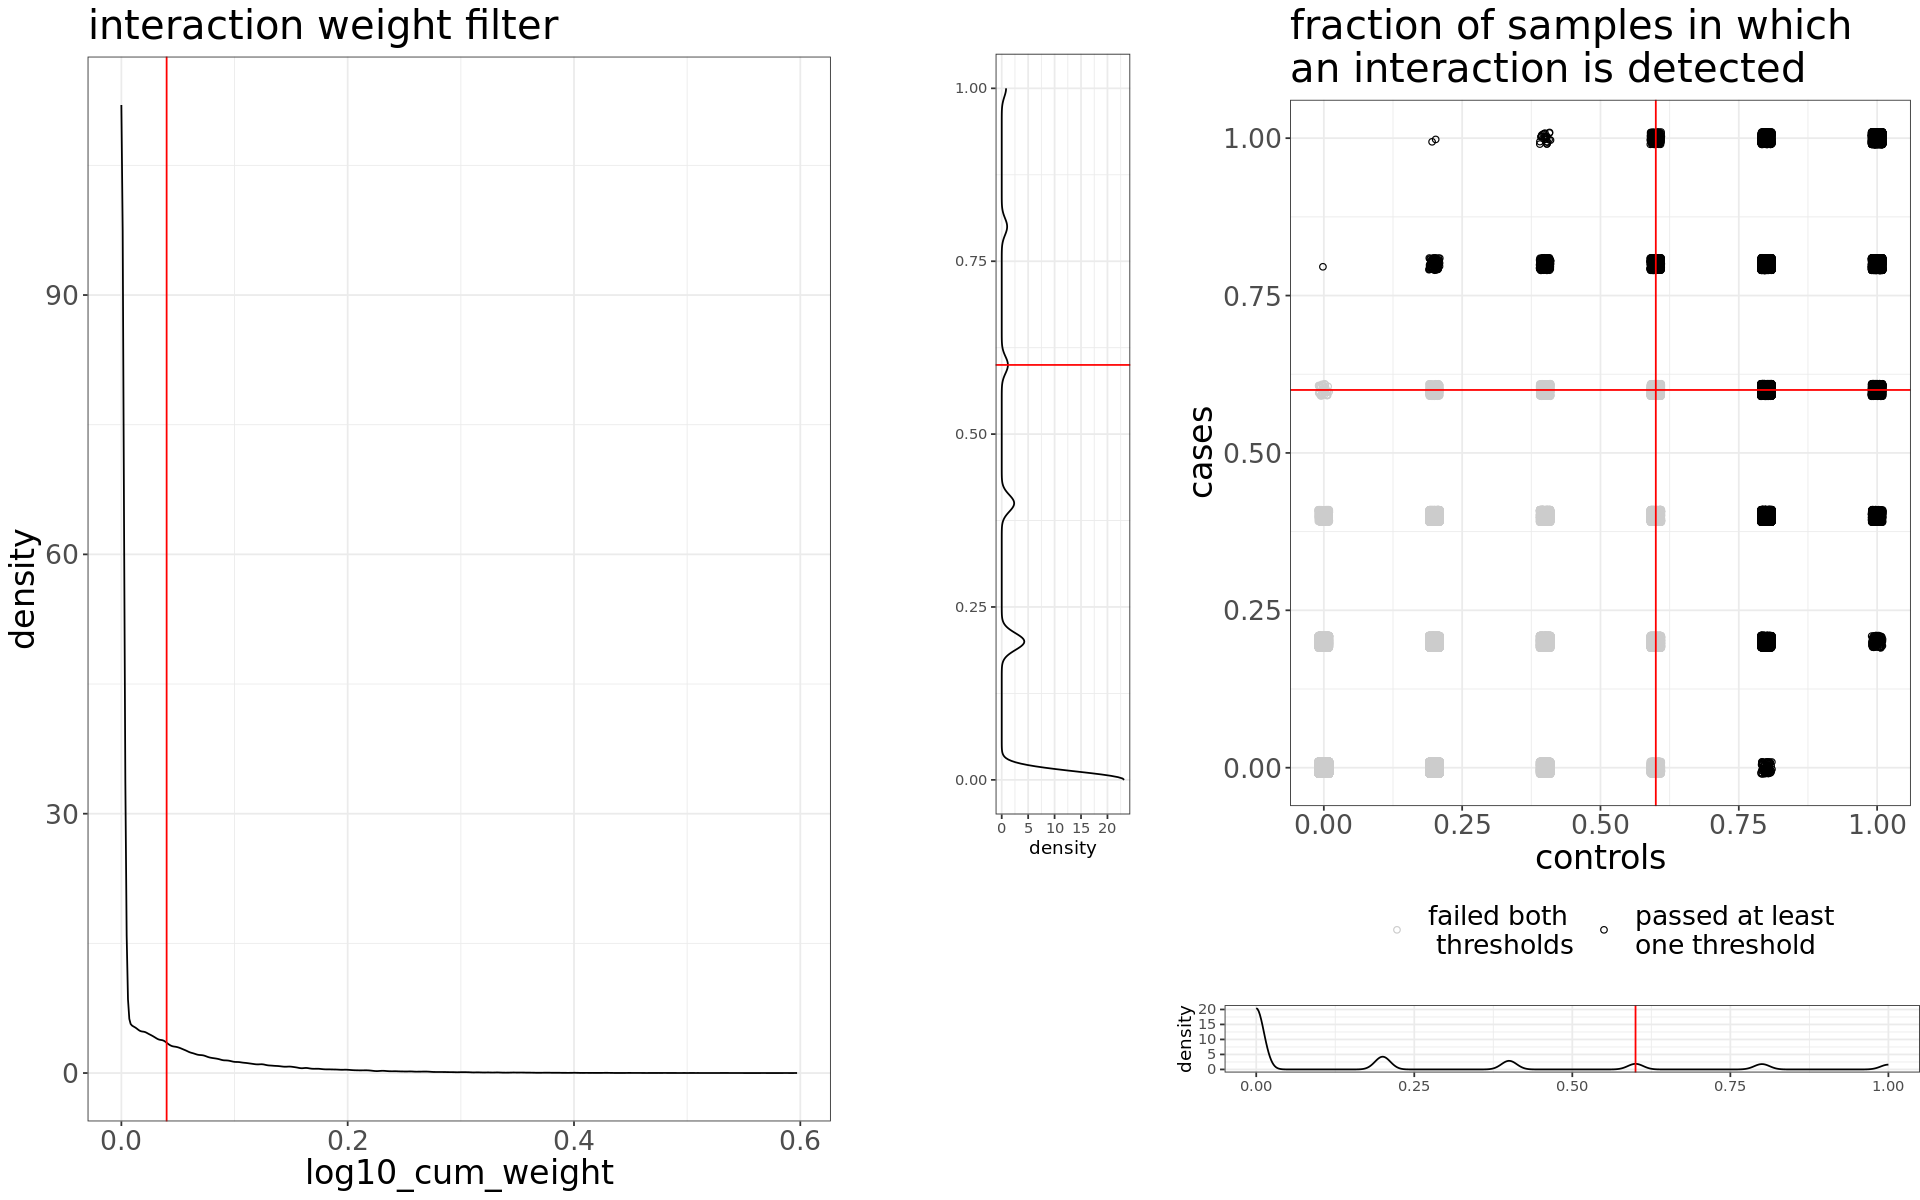

[1] "154138 out of 170688 interactions do not pass the thresholds for log10 cumulative interactions weight > 0.04 and fraction of expressing samples > 0.6 . Also  16954  interactions didn't pass the discrepancy filter.  In total, 154138  bad quality interactions will be removed and 16550 good quality interactions will remain."


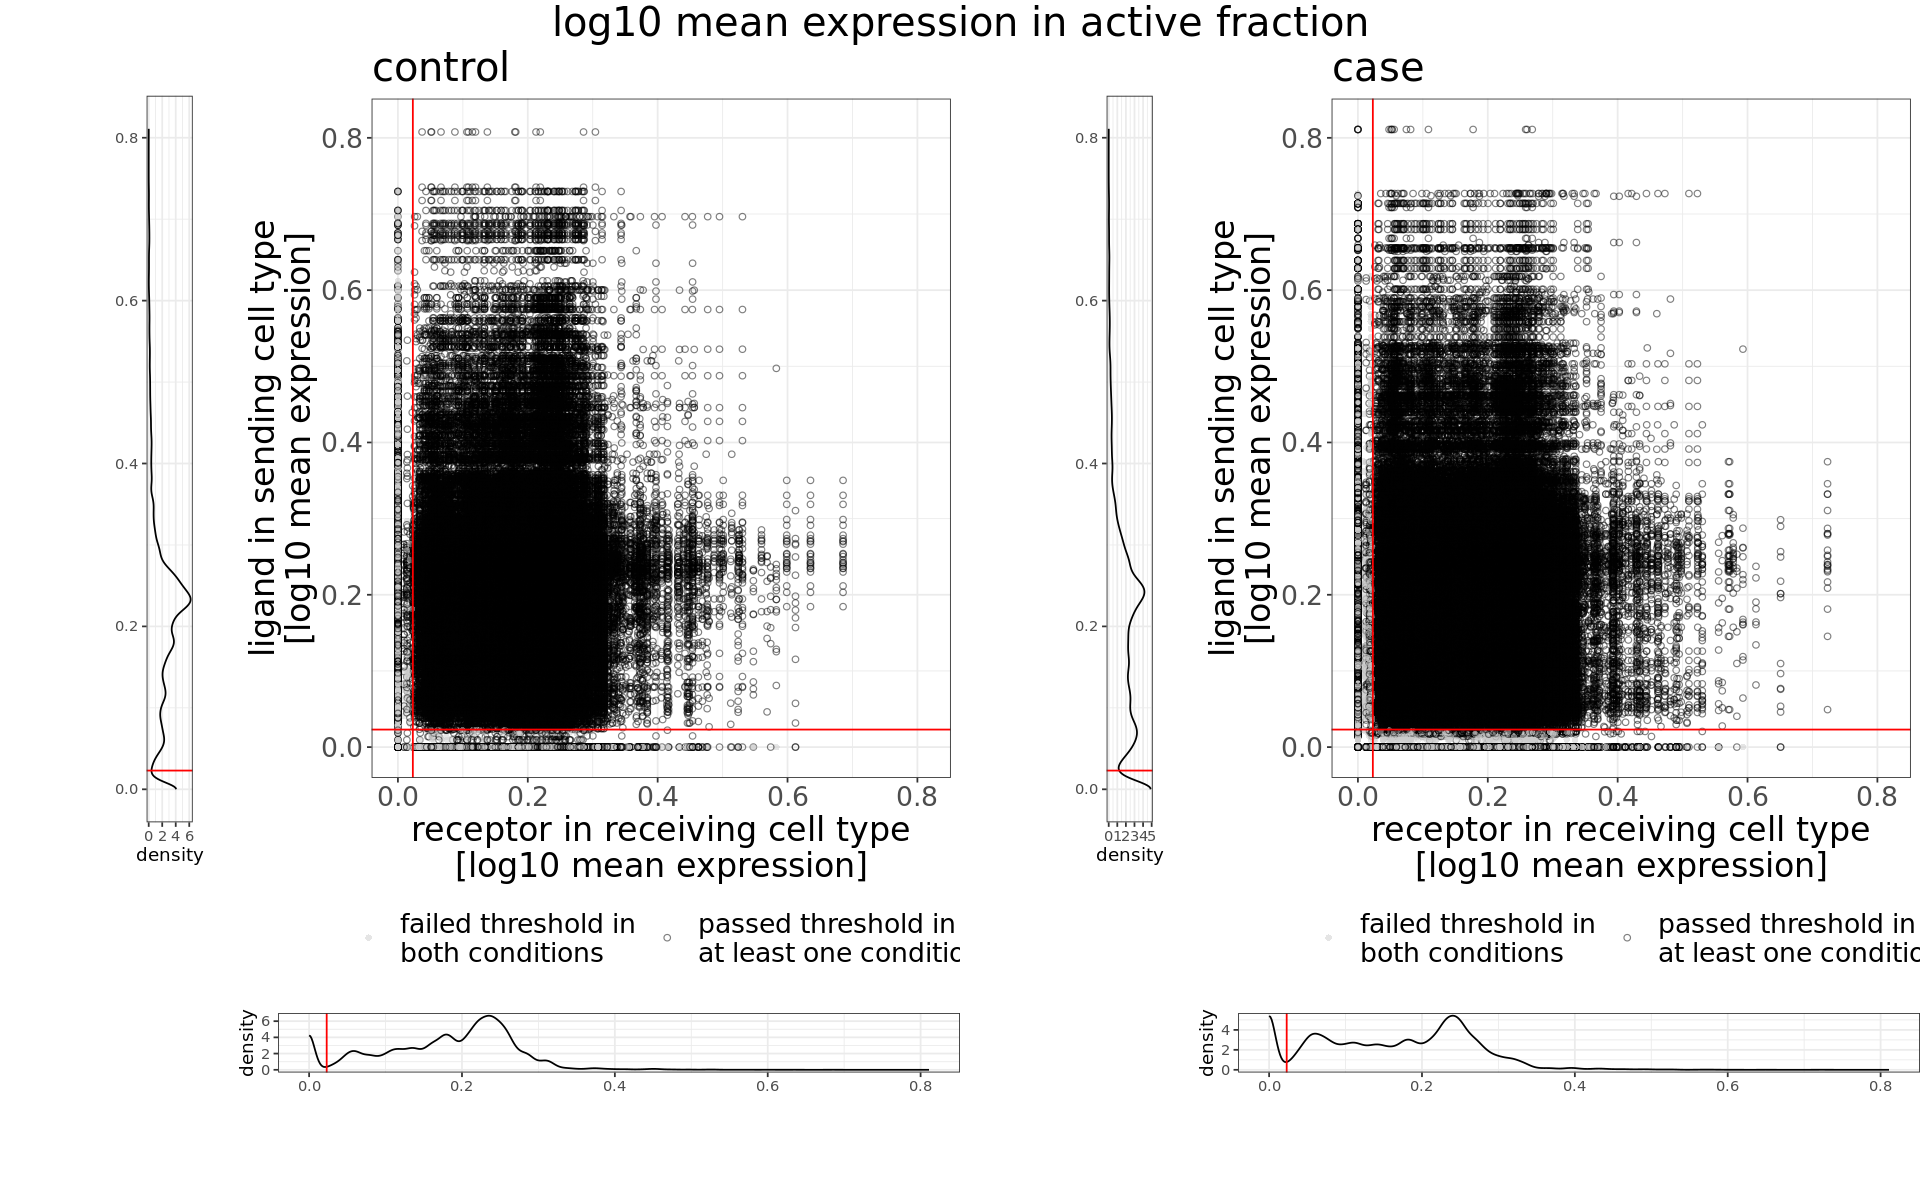

In [21]:
print("filter weak interactions")

options(repr.plot.height = 10
       ,repr.plot.width = 16)
interactions <- filter_interactions(comm_result = interactions
                             ,threshold_frac_samples_per_condition = threshold_frac_samples_per_condition
                             ,threshold_log10_cum_weight = threshold_log10_cum_weight
                             ,threshold_log10_meanexpr_per_condition = threshold_log10_meanexpr_per_condition
)

In [22]:
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

List of 6
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.04
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.023
NULL
'data.frame':	170688 obs. of  28 variables:
 $ interaction_ID                            : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name                          : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type                         : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ receiving_cell_type                       : chr  "Epithelial" "Epithelial" "Epithelial" "Epithelial" ...
 $ mean_e_s_l_control                 

# Differential Communication

For calculating statistically significant differential interactions between the cases and the controls, we need to define an adjusted p-value threhsold and the log2 fold change threshold. 

In [23]:
# Set up log2 fold change threshold. The default value is 1
threshold_log2FC <- 1
print(paste("[absolute] threshold_log2FC >",threshold_log2FC))

[1] "[absolute] threshold_log2FC > 1"


In [24]:
# Set up FDR threshold. The default value is 0.1
threshold_fdr <- 0.1
print(paste("threshold_fdr <",threshold_fdr))

[1] "threshold_fdr < 0.1"


The `test_diff` function stores the thresholds in the `thresholds` list of the interactions object.

The `test_diff` function calculates a p-value for each interaction using a Wilcoxon test and adjusts for multiple testing using the FDR correction method. After that, the function checks whether the log2 fold change and the adjusted p-value thresholds were passed. An interactoin is considered significant if it passes both threshodls. The `test_diff` function stores the results as boolean vector to the `anno_interactions` list of the interactions object.

In [25]:
print("calculate differential communication")
interactions <- test_diff(comm_result = interactions
                          ,threshold_fdr = threshold_fdr
                          ,which_test = "t-test"
                          ,threshold_log2FC = threshold_log2FC
                          
                         )
print(str(interactions$thresholds))
print(str(interactions$anno_interactions))

[1] "calculate differential communication"
[1] "We have 0 dignificantly differential interactions"
List of 8
 $ threshold_expr                        : num 0.1
 $ threshold_nr_active_cells             : num 6
 $ threshold_celltype_size               : num 6
 $ threshold_log10_cum_weight            : num 0.04
 $ threshold_frac_samples_per_condition  : num 0.6
 $ threshold_log10_meanexpr_per_condition: num 0.023
 $ threshold_fdr                         : num 0.1
 $ threshold_log2FC                      : num 1
NULL
'data.frame':	170688 obs. of  33 variables:
 $ interaction_ID                            : chr  "Epithelial:ADAM12_Epithelial:ITGB1" "Epithelial:ADAM12_Epithelial:SDC4" "Epithelial:ADAM15_Epithelial:ITGA5" "Epithelial:ADAM15_Epithelial:ITGA9" ...
 $ ligand_gene_name                          : chr  "ADAM12" "ADAM12" "ADAM15" "ADAM15" ...
 $ receptor_gene_name                        : chr  "ITGB1" "SDC4" "ITGA5" "ITGA9" ...
 $ sending_cell_type                         : chr  "Ep

# Visualisation

In [26]:
idx_up <- interactions$anno_interactions$log2FC_weights >1
idx_unchanged <- abs(interactions$anno_interactions$log2FC_weights)<=1
idx_down <- interactions$anno_interactions$log2FC_weights < -1
idx_sign <- !is.na(interactions$anno_interactions$sign) & interactions$anno_interactions$sign
idx_good <- interactions$anno_interactions$passed_QC_filter

In [27]:
cell_types <- unique(interactions$anno_cells$cell_type)
print(cell_types)

[1] "Epithelial"  "Fibroblasts" "Endothelial" "Myeloid"     "Mast"       
[6] "T-cells"     "Plasma"      "B-cells"    


### Mean weight of good quality edges

In [28]:
# dir.create("/figures")

            Epithelial Fibroblasts Endothelial    Myeloid       Mast    T-cells
Epithelial  0.09137767  0.03134919  0.03347104 0.03580703 0.06053926 0.03416006
Fibroblasts 0.03726781  0.02018102  0.03129625 0.02517019 0.05973714 0.02599620
Endothelial 0.03437818  0.02589939  0.05239060 0.01867313 0.09386210 0.04445610
Myeloid     0.04639861  0.02240391  0.02060663 0.03779725 0.06503206 0.03370800
Mast        0.06956491  0.03655753  0.08483057 0.03457892 0.14459286 0.07807460
T-cells     0.03761873  0.01792789  0.03750328 0.02446837 0.08321841 0.04185021
Plasma      0.02857531  0.01211161  0.01139303 0.02174289 0.01738569 0.01407647
B-cells     0.02357404  0.02060149  0.02889417 0.03940471 0.03375258 0.04085691
                Plasma    B-cells
Epithelial  0.02582602 0.02324444
Fibroblasts 0.01335597 0.02126498
Endothelial 0.00999635 0.02742914
Myeloid     0.02237515 0.03585370
Mast        0.01284046 0.03440675
T-cells     0.01139747 0.03662348
Plasma      0.01180327 0.01910742
B-cells 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


             Epithelial Fibroblasts Endothelial    Myeloid        Mast
Epithelial  0.013674683  0.01891893 0.009775157 0.02359732 0.008023406
Fibroblasts 0.020346393  0.05502580 0.033702658 0.08491715 0.020951131
Endothelial 0.010314172  0.03421222 0.020794056 0.05489088 0.009274508
Myeloid     0.024741354  0.08092130 0.053741402 0.16623321 0.039899125
Mast        0.008211003  0.02089365 0.010173583 0.04154276 0.011433728
T-cells     0.024810613  0.07085965 0.045051078 0.13679739 0.030143439
Plasma      0.024223401  0.03318967 0.022247017 0.06722099 0.028426758
B-cells     0.005111349  0.01913087 0.014864396 0.07250592 0.010911707
               T-cells     Plasma     B-cells
Epithelial  0.02517048 0.02306409 0.006123811
Fibroblasts 0.08760884 0.03480181 0.024014584
Endothelial 0.05507393 0.02082095 0.020364362
Myeloid     0.15712103 0.06163044 0.076287091
Mast        0.03932315 0.02612115 0.013019631
T-cells     0.13284520 0.05231619 0.050425243
Plasma      0.05910626 0.05132058 0.033

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

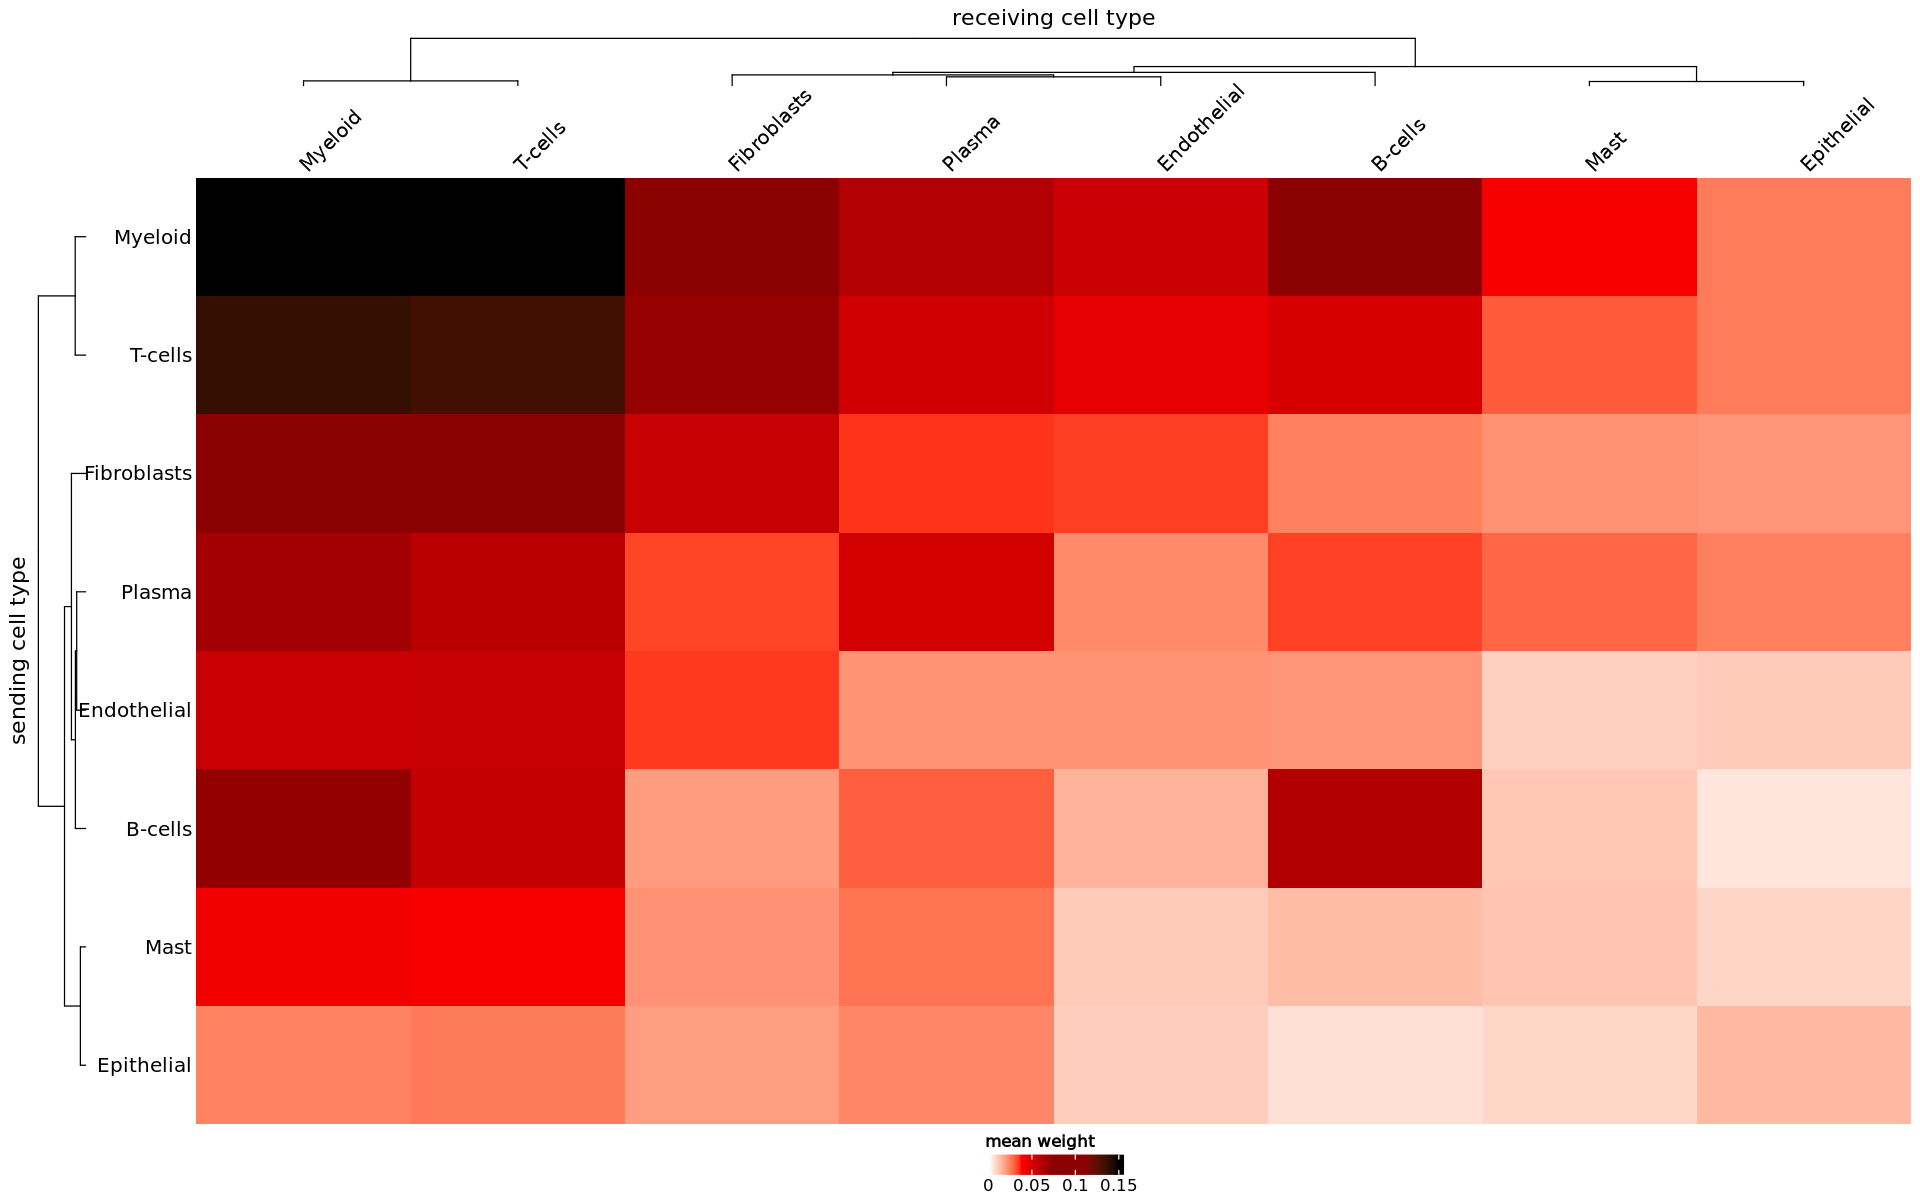

In [29]:
# heatmap of total weight of good interactions
lapply(c(unique(interactions$anno_samples$region))
      ,function(hs){
          
          idx_hs <- interactions$anno_samples$region == hs
          
          # number of interactions as heatmap
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types

    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send

        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec

            #print(send)
            #print(rec)
            #print(head(interactions$anno_interactions[idx_good & idx_send & idx_rec,c("interaction_ID"
            #                                                                          ,"log2FC_weights"
            #                                                                          , "sign")]))
            #print(sum(idx_good & idx_send & idx_rec))

            weights <- interactions$weights[idx_good & idx_send & idx_rec,idx_hs]
            #ifelse(length(weights) == 0
            #      ,df[send,rec] <- 0
                 # ,
            df[send,rec] <- mean(unlist(weights))
             #     )
            

        }
    }

    print(df)

    my_color <-  colorRamp2(seq(0
                                , 0.15 #max(df)
                                , length = 5)
                            , c("white", "red", "red4",  "darkred", "black"))

    h <- Heatmap(df
                 ,name = "mean weight"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                 ,column_title = "receiving cell type"
                 ,row_title = "sending cell type"
                 #,cluster_columns=FALSE
                 #,cluster_rows=FALSE
                 #,row_order = c("HSPC", "DC", "Mono", "Ery", "B", "T")
                 #,column_order = c("HSPC","DC", "Mono", "Ery", "B", "T")
                 ,column_names_rot = 45
                )
          ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")

    pdf(file=paste0("figures/heatmap_cellTypes_meanWeight_ni_"
                    ,hs
                    ,".pdf"))
         ComplexHeatmap::draw(h
             ,heatmap_legend_side = "bottom")
           dev.off()
      })

### Volcano plot

We can now visualize the interactions with a volcano plot. 

Warning message:
“Removed 1 rows containing missing values (`geom_hline()`).”


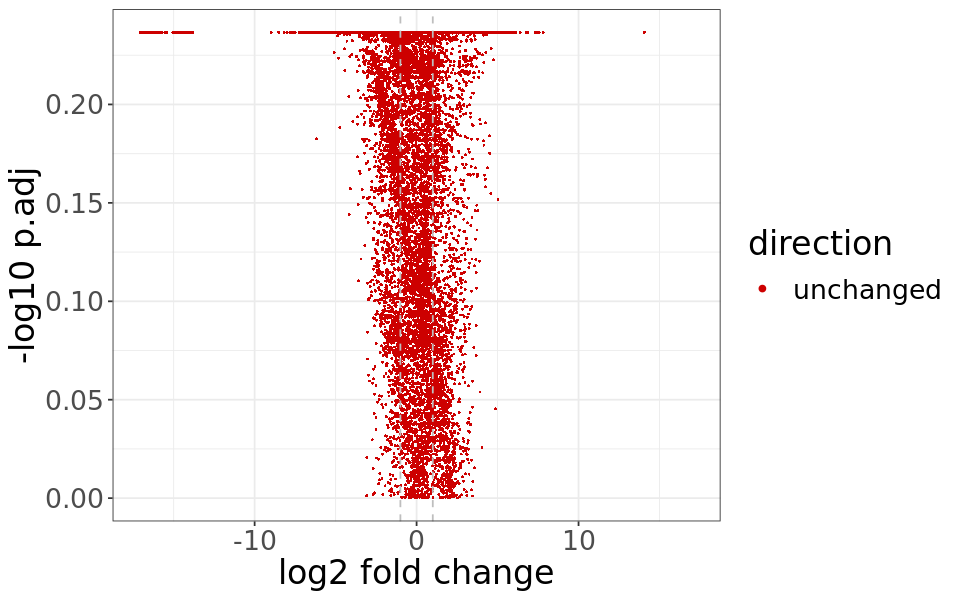

In [30]:
# volcano plot
options(repr.plot.height = 5
       ,repr.plot.width = 8)

df <- data.frame(log2FC = interactions$anno_interactions$log2FC_weights[idx_good]
                 ,y = -log10(interactions$anno_interactions$p.adj[idx_good])
                 ,significant = interactions$anno_interactions$sign[idx_good]
                )

df$direction <- "unchanged"
df$direction[df$significant & (df$log2FC > 1)] <- "up"
df$direction[df$significant & (df$log2FC < -1)] <- "down"
df$direction <- factor(df$direction
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                      ,ordered = TRUE)

xlab <- "log2 fold change"
ylab <- "-log10 p.adj"

xlim <- c(-max(abs(df$log2FC))
          ,max(abs(df$log2FC))
         )
ylim <- c(0, max(df$y))

p <- ggplot(data = df
            ,aes(x = log2FC
                 ,y = y
                 ,color = direction
                 ,size = significant
                 ,shape = significant
                ))+
geom_point()+
scale_color_manual(values = c("red3"
                               ,"gray95"
                               ,"blue3"))+
scale_size_manual(values = c(0.5, 1.5))+
guides(size = "none"
      ,shape = "none")+
xlab(xlab)+
ylab(ylab)+
xlim( xlim )+
ylim(ylim)+
theme_bw()+
theme(text = element_text(size=20))+
geom_vline(xintercept = interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_vline(xintercept = -interactions$thresholds$threshold_log2FC
          ,lty = 2
          ,color = "gray")+
geom_hline(yintercept = -log10(interactions$thresholds$threshold_fdr)
          ,lty = 2
          ,color = "gray")
p




  up unchanged down
1  0     16550    0


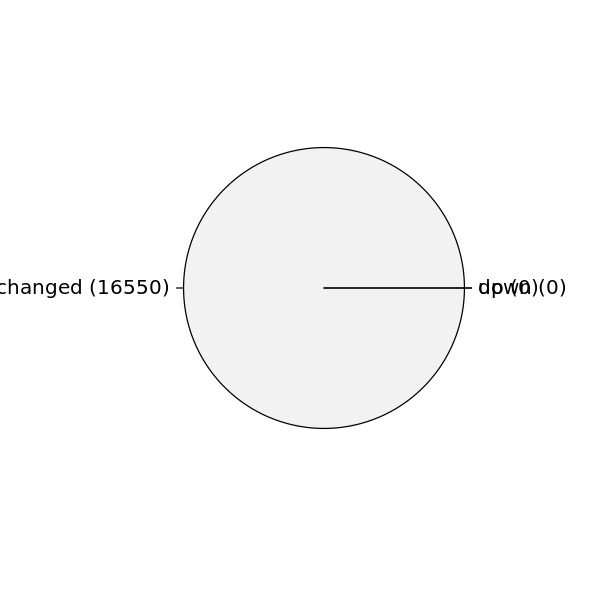

In [31]:
# pie chart
df <- data.frame(up = sum(idx_good & idx_sign & idx_up)
                ,unchanged = sum(idx_good & !idx_sign)
                , down = sum(idx_good & idx_sign & idx_down)
                )
print(df)

options(repr.plot.width = 5
       ,repr.plot.height = 5)
pie(unlist(df)
   ,labels = paste0(colnames(df)," (",unlist(df), ")")
   ,col = c("red3"
           ,"gray95"
           ,"blue3")) 

### Heatmap of top differential interactions

In [32]:
# heatmap of interactions weight of top differential interactions
# top adjusted p value
idx_topsign <- interactions$anno_interactions$p.adj %in% unique(sort(interactions$anno_interactions$p.adj))[1:500]
# all upregulated interactions
idx_topup <- interactions$anno_interactions$log2FC_weights > 1 & idx_topsign

# top 20 downregulated interactions
idx_topdown <- interactions$anno_interactions$log2FC_weights < -1 & idx_topsign
idx_topdown20 <- interactions$anno_interactions$interaction_ID %in% interactions$anno_interactions$interaction_ID[idx_topdown][1:20]

idx <- idx_topup | idx_topdown20
print(sum(idx))

[1] 1818


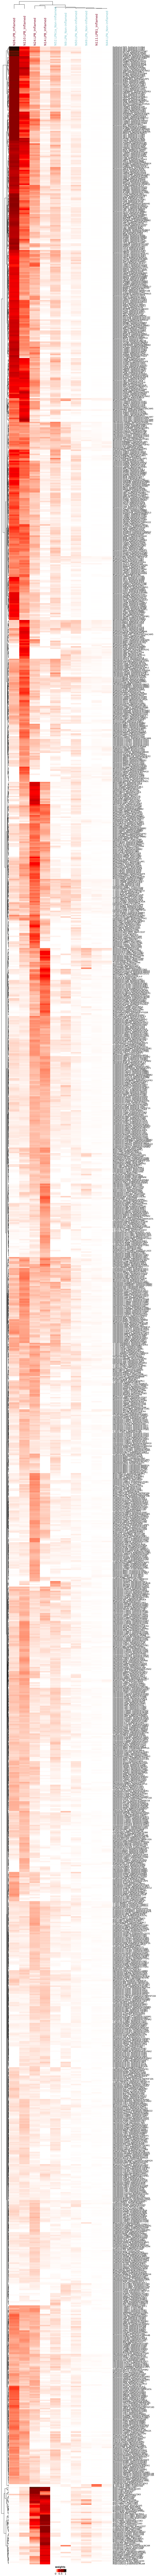

In [33]:
set.seed(1)
options(repr.plot.height = 140
       ,repr.plot.width = 8.5)
plot_heatmap(interactions
            ,which_interactions = idx
            ,values_to_plot = "weights")

#### Individual parameters

    cell_type log2FC_rho
5        Mast  1.4563336
1  Epithelial  1.4259708
3 Endothelial  0.5256074
8     B-cells  0.3559277
6     T-cells -0.5841291
2 Fibroblasts -0.5893529
7      Plasma -0.7778643
4     Myeloid -0.8801766


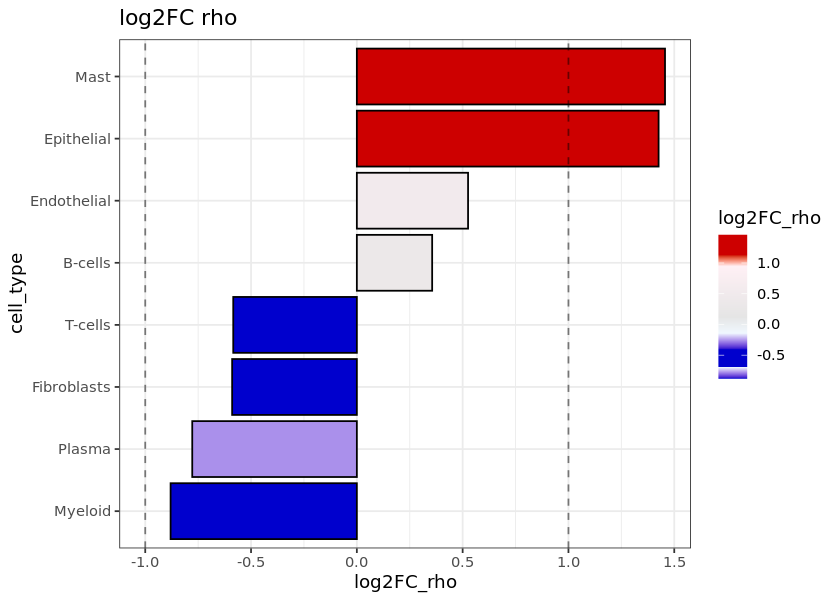

In [34]:
# plot log2FC rho for cell types
df <- data.frame(cell_type = cell_types)
df$log2FC_rho <- sapply(cell_types
                       ,function(ct){
                           idx_ct <- interactions$anno_interactions$sending_cell_type == ct # just take the sending
                         interactions$anno_interactions$log2FC_rho_s[idx_ct][1] # just take the first one
                       })
df <- df[order(df$log2FC_rho,decreasing = TRUE),]
df$cell_type <- factor(df$cell_type
                         ,levels = df$cell_type
                         ,ordered = TRUE)
print(df)

my_values <- c(min(df$log2FC_rho),-1.1,-0.9,0,0.9,1.1,max(df$log2FC_rho))
my_colors <- c("blue3","blue3","aliceblue","gray90","lavenderblush","red3","red3")
names(my_colors) <- my_values
resc_values <- rescale(as.numeric(names(my_colors)))

options(repr.plot.width = 7
       ,repr.plot.height = 5)
ggplot(data = df
      ,aes(x = cell_type
          ,y = log2FC_rho
          ,fill = log2FC_rho)
      )+
geom_col(color = "black")+
scale_fill_gradientn(colours = my_colors
                           ,values = resc_values
                          )+
geom_hline(yintercept = c(-1,1)
          ,lty = 2
          ,lwd = 0.5
          ,alpha = 0.5)+
ggtitle("log2FC rho")+
scale_x_discrete(limits = rev)+ # reverse order on the x axis
coord_flip()+
theme_bw()

'data.frame':	197592 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 8 levels "Epithelial"<"Fibroblasts"<..: 1 1 1 1 1 1 1 1 1 1 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


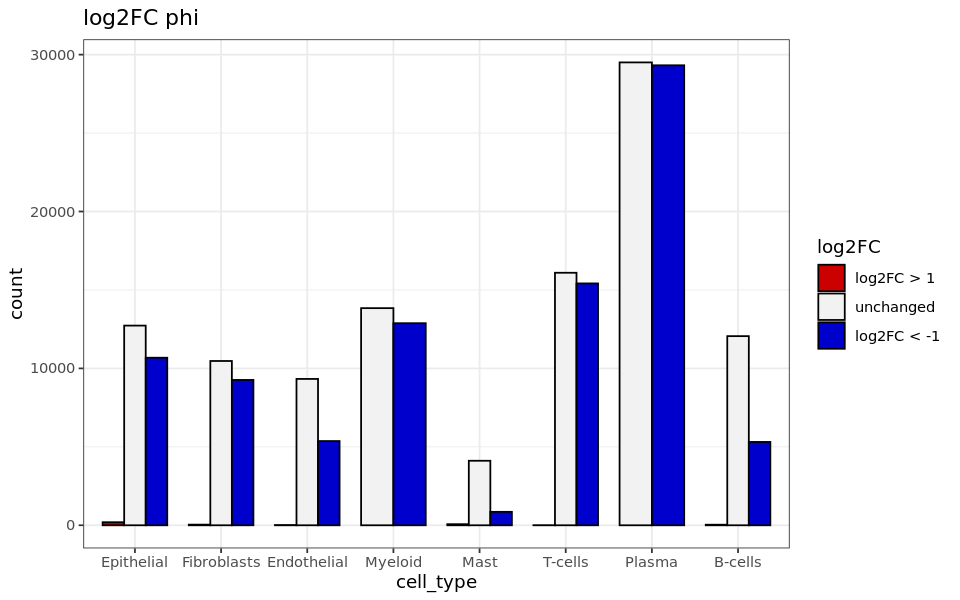

In [35]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_phi_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_phi_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_phi_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_phi_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c(unique(anno_cells$cell_type))
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                       ,labels = c("log2FC > 1"
                                  ,"unchanged"
                                  ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC phi")+
    #ylim(c(0,3500))+
    theme_bw()

p

'data.frame':	146403 obs. of  2 variables:
 $ cell_type: Ord.factor w/ 8 levels "Epithelial"<"Fibroblasts"<..: 1 1 1 1 1 7 7 7 7 7 ...
 $ log2FC   : Ord.factor w/ 3 levels "log2FC > 1"<"unchanged"<..: 1 1 1 1 1 1 1 1 1 1 ...
NULL


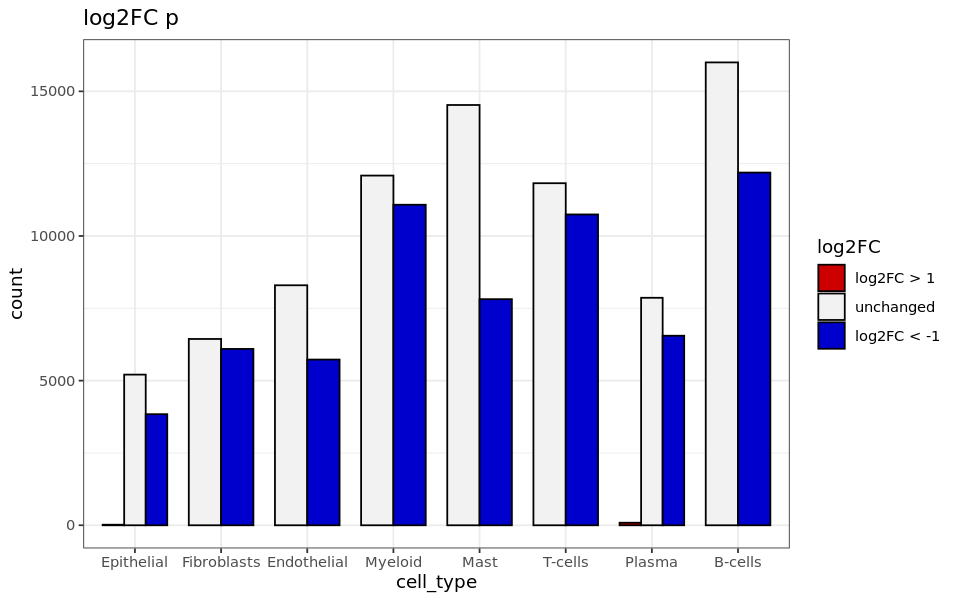

In [36]:
# phi log2FC by cell type
df <- lapply(c("up"
                    ,"unchanged"
                    ,"down")
                   ,function(dir){
                       if(dir == "up"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l > 1 & idx_good
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r > 1 & idx_good
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }else if(dir == "down"){
                           idx_send <-interactions$anno_interactions$log2FC_p_s_l < -1 
                           idx_rec <- interactions$anno_interactions$log2FC_p_r_r < -1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       } else {
                           idx_send <- abs(interactions$anno_interactions$log2FC_p_s_l) > 1 
                           idx_rec <- abs(interactions$anno_interactions$log2FC_p_r_r) > 1
                           my_df <- data.frame(cell_type = c(interactions$anno_interactions$sending_cell_type[idx_send]
                                                             ,interactions$anno_interactions$receiving_cell_type[idx_rec])
                                               ,log2FC = rep(dir,sum(idx_send) + sum(idx_rec))
                                              )
                           my_df
                       }
                       
                   }
                       )
df <- rbind(df[[1]],df[[2]],df[[3]])
df$cell_type <- factor(df$cell_type
                         ,levels = c(unique(anno_cells$cell_type))
                         ,ordered = TRUE)
df$log2FC <- factor(df$log2FC
                      ,levels = c("up"
                                 ,"unchanged"
                                 ,"down")
                    ,labels = c("log2FC > 1"
                               ,"unchanged"
                               ,"log2FC < -1")
                      ,ordered = TRUE)
print(str(df))

           
options(repr.plot.width = 8
       ,repr.plot.height = 5)
p <- ggplot(data = df
          ,aes(x = cell_type
               ,fill = log2FC
              )
           )+
    geom_bar(position = "dodge"
            ,width=.75
            ,color = "black")+
scale_fill_manual(values = c("red3","gray95","blue3"))+
    ggtitle("log2FC p")+
    #ylim(c(0,3500))+
    theme_bw()

p

### Classes of interactions

In this section, we will check which of the individual components (rho, phi, p) are driving the change of the interactions. For this, we will combine following forest plots: 
- log2 fold change of the interaction weight (`w`)
- log2 fold change of the cell type abundance of the sending cell type (`rho_s`)
- log2 fold change of the active fraction of the sending cell type expressing the ligand (`phi_s_l`)
- log2 fold change of the expression of the sending cell type expressing the ligand (`p_s_l`)
- log2 fold change of the cell type abundance of the receiving cell type (`rho_r`)
- log2 fold change of the active fraction of the receiving cell type expressing the receptor (`phi_r_r`)
- log2 fold change of the expression of the receiving cell type expressing the receptor (`p_r_r`)

We will first explore the interaction that were unchanged. We will start with the interactions that had a trully unchanged log2 fold change of the weight (i.e. -1 < `log2FC_weight` < 1), and then plot the interactions with eigther up- or down-regulated log2 fold change of the weight, which though didn't pass the adjusted p-value threshold.

#### Unchanged

In [37]:
idx_of_interest <- !idx_sign & idx_good
sum(idx_of_interest)

[1] 16550

 No log2FC of the w.

In [38]:
idx_w <- abs(interactions$anno_interactions$log2FC_weights) < 1
sum(idx_of_interest & idx_w)

[1] 5308

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "2507 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "2003 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "6 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "271 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "4 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "1 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "1 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "2 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "447 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "6 inter

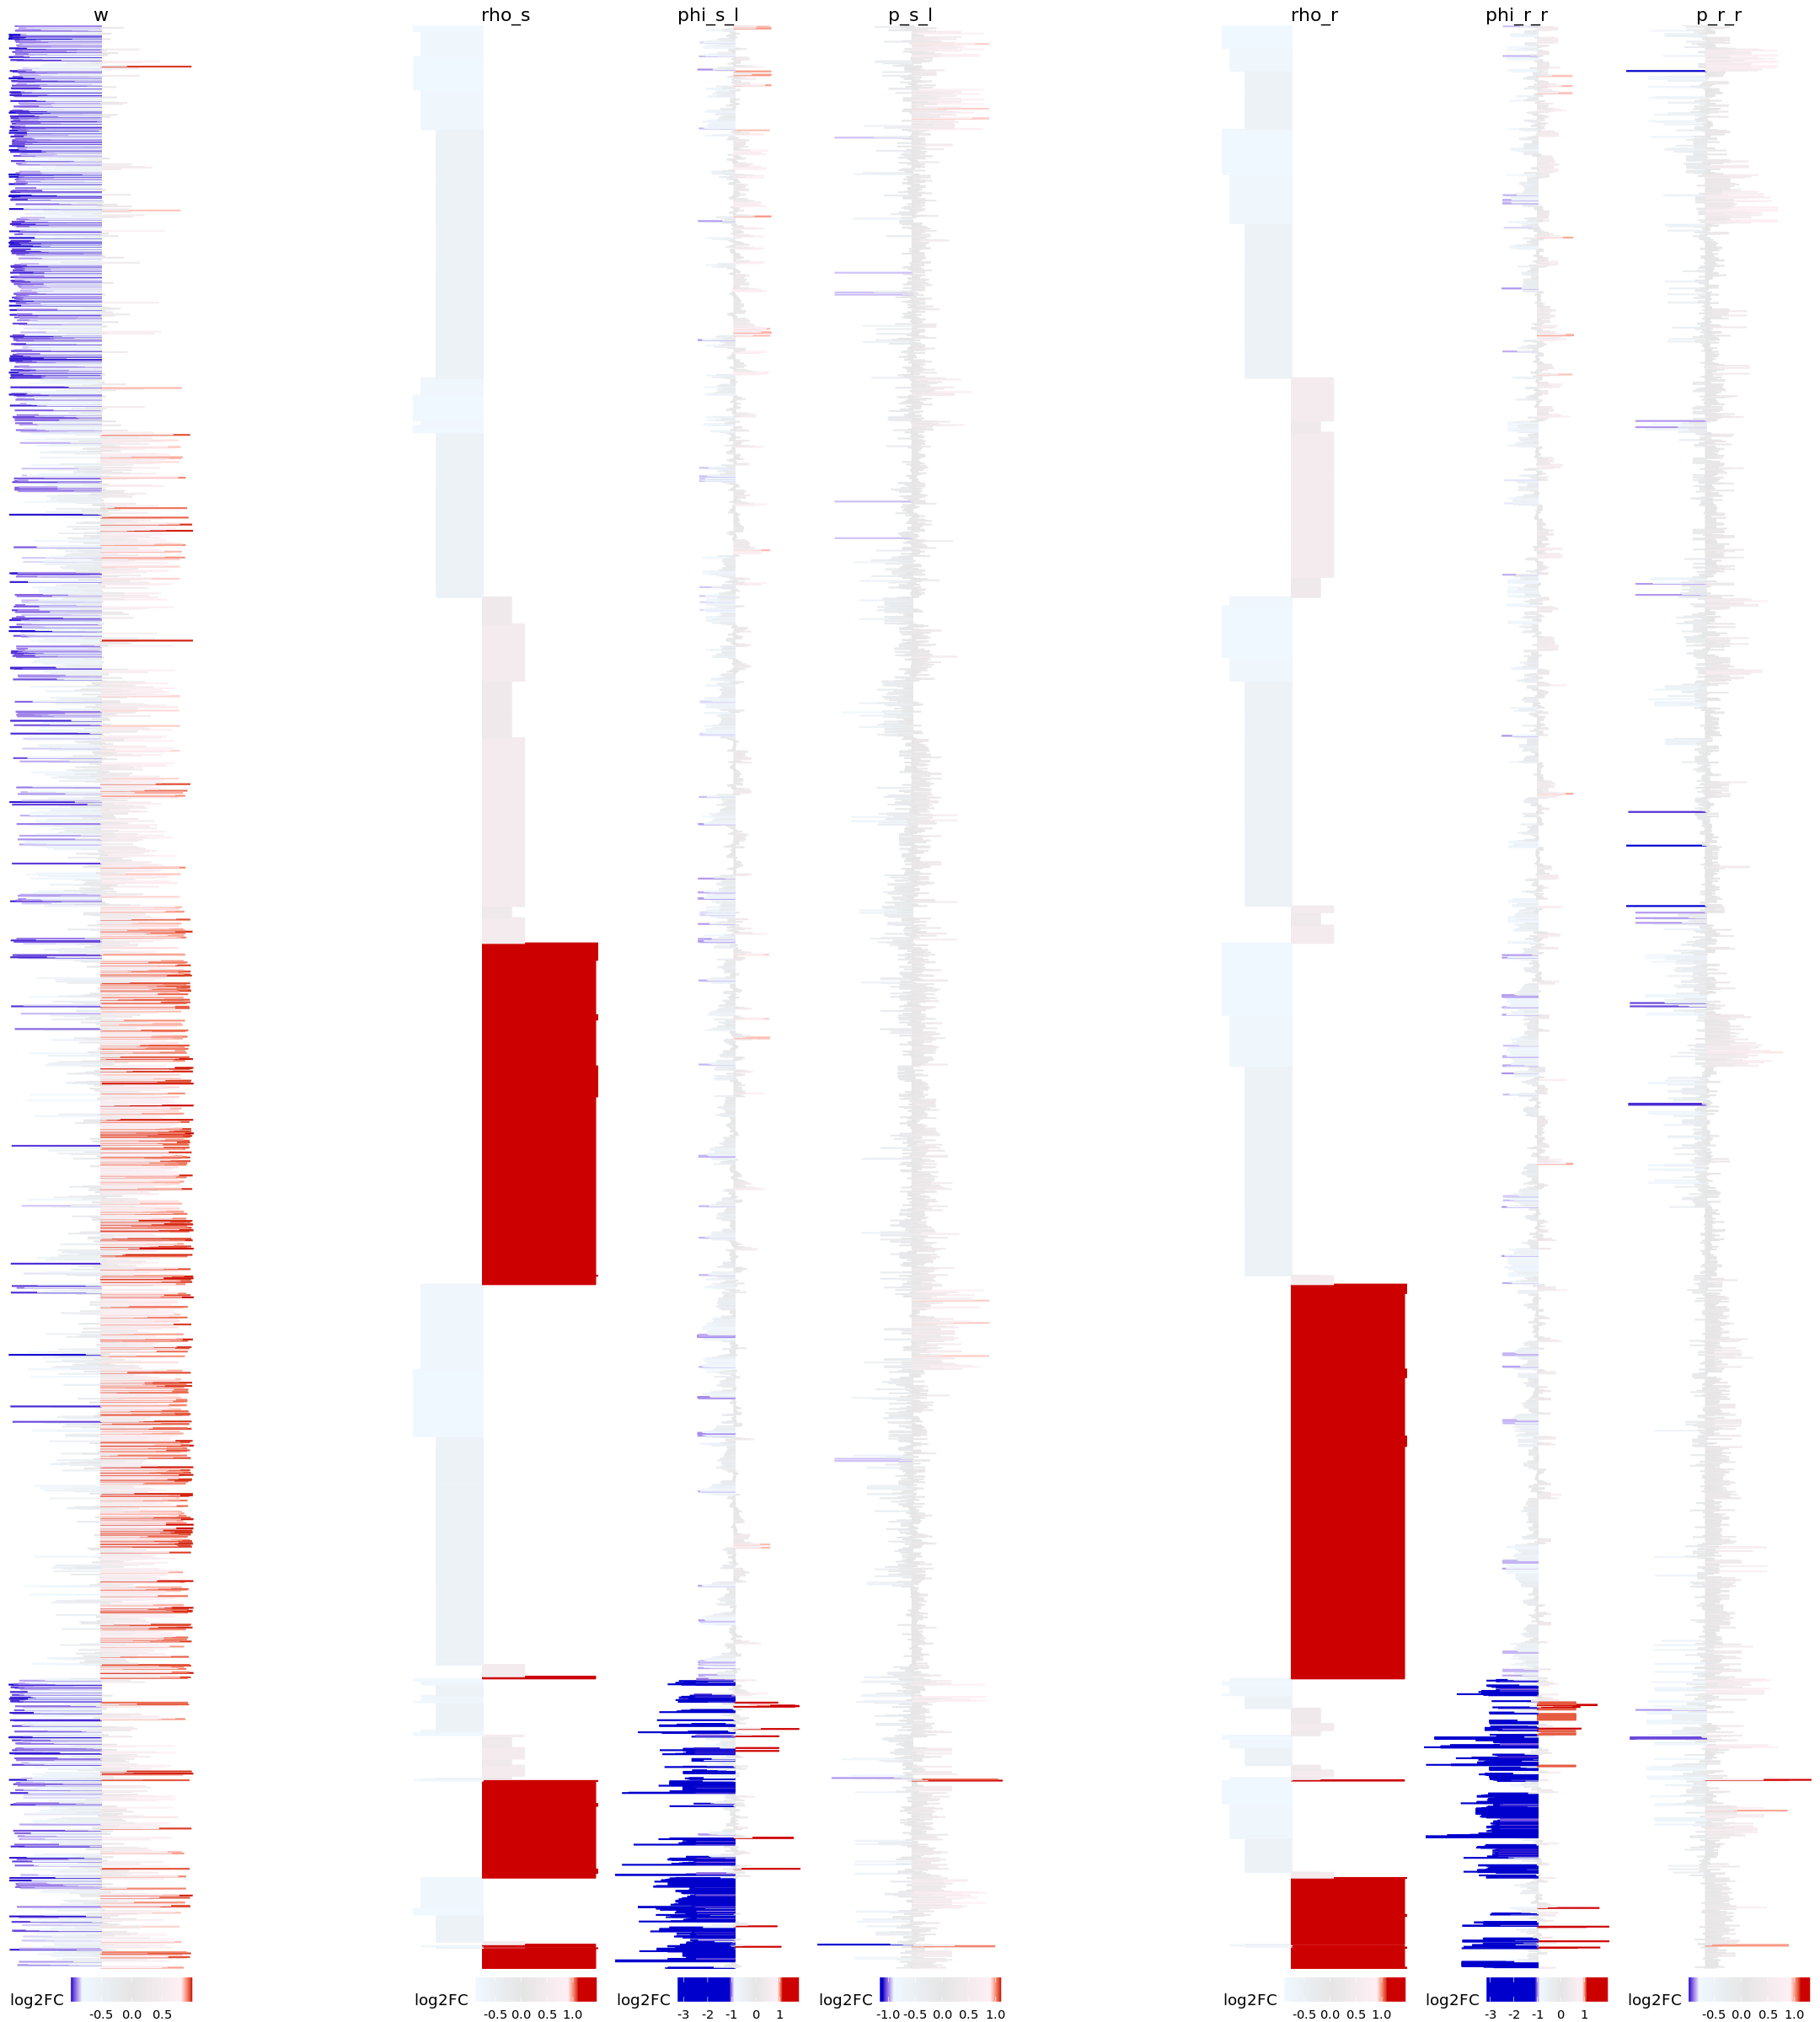

In [39]:
options(repr.plot.height = 20
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w > 1, but is not significant.

In [40]:
idx_w <- interactions$anno_interactions$log2FC_weights > 1
sum(idx_of_interest & idx_w)

[1] 3544

In [41]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions, plot_legend=FALSE)

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "284 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "2072 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "815 interactions"


<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>

ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

Log2FC of w < -1, but is not significant.

In [42]:
idx_w <- interactions$anno_interactions$log2FC_weights < -1
sum(idx_of_interest & idx_w)

[1] 7698

In [43]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest & idx_w
                ,my_anno_interactions = interactions$anno_interactions)

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "3992 interactions"


<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Up-regulated

Now we will explore the interactions in which the `log2FC_weights` passed the upper log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [44]:
idx_of_interest <- idx_good & idx_sign & idx_up
sum(idx_of_interest)

[1] 0

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "0 interactions"
[

Warning message in min(my_data$log2FC_weights$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_weights$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_rho_s$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_rho_s$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_phi_s_l$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_phi_s_l$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_p_s_l$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_p_s_l$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_rho_r$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück

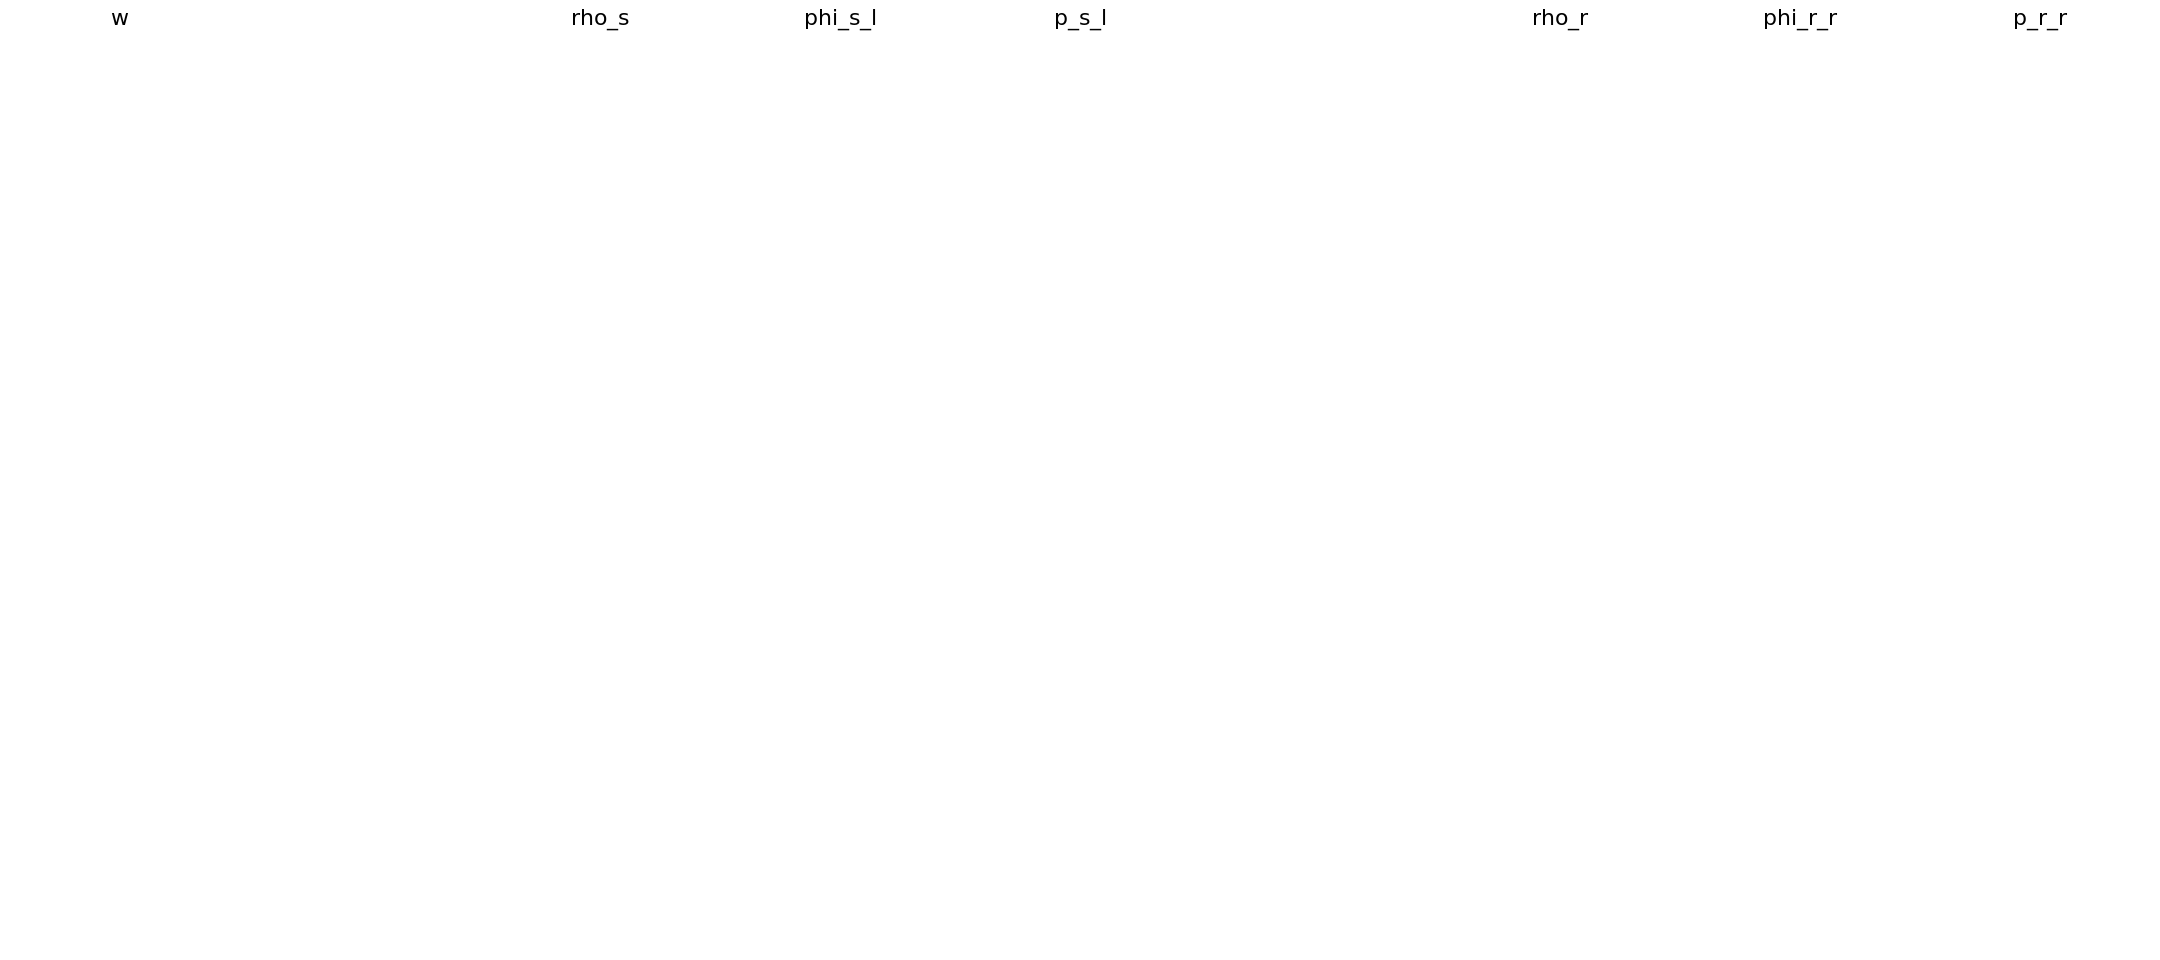

In [45]:
options(repr.plot.height = 8
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

#### Down-regulated

Here we will explore the interactions in which the `log2FC_weights` passed the lower log2 fold change threshodl, but didn't pass the adjusted p-value threshold.

In [46]:
idx_of_interest <- idx_good & idx_sign & idx_down
sum(idx_of_interest)

[1] 0

[1] "rho"  "none" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "both" "phi"  "none" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "none"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "one"  "p"    "both"
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "none" "phi"  "both" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "one" 
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "none" "p"    "both"
[1] "0 interactions"
[1] "rho"  "one"  "phi"  "one"  "p"    "none"
[1] "0 interactions"
[1] "rho" "one" "phi" "one" "p"   "one"
[1] "0 interactions"
[

Warning message in min(my_data$log2FC_weights$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_weights$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_rho_s$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_rho_s$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_phi_s_l$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_phi_s_l$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_p_s_l$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück”
Warning message in max(my_data$log2FC_p_s_l$log2FC):
“kein nicht-fehlendes Argument für max; gebe -Inf zurück”
Warning message in min(my_data$log2FC_rho_r$log2FC):
“kein nicht-fehlendes Argument für min; gebe Inf zurück

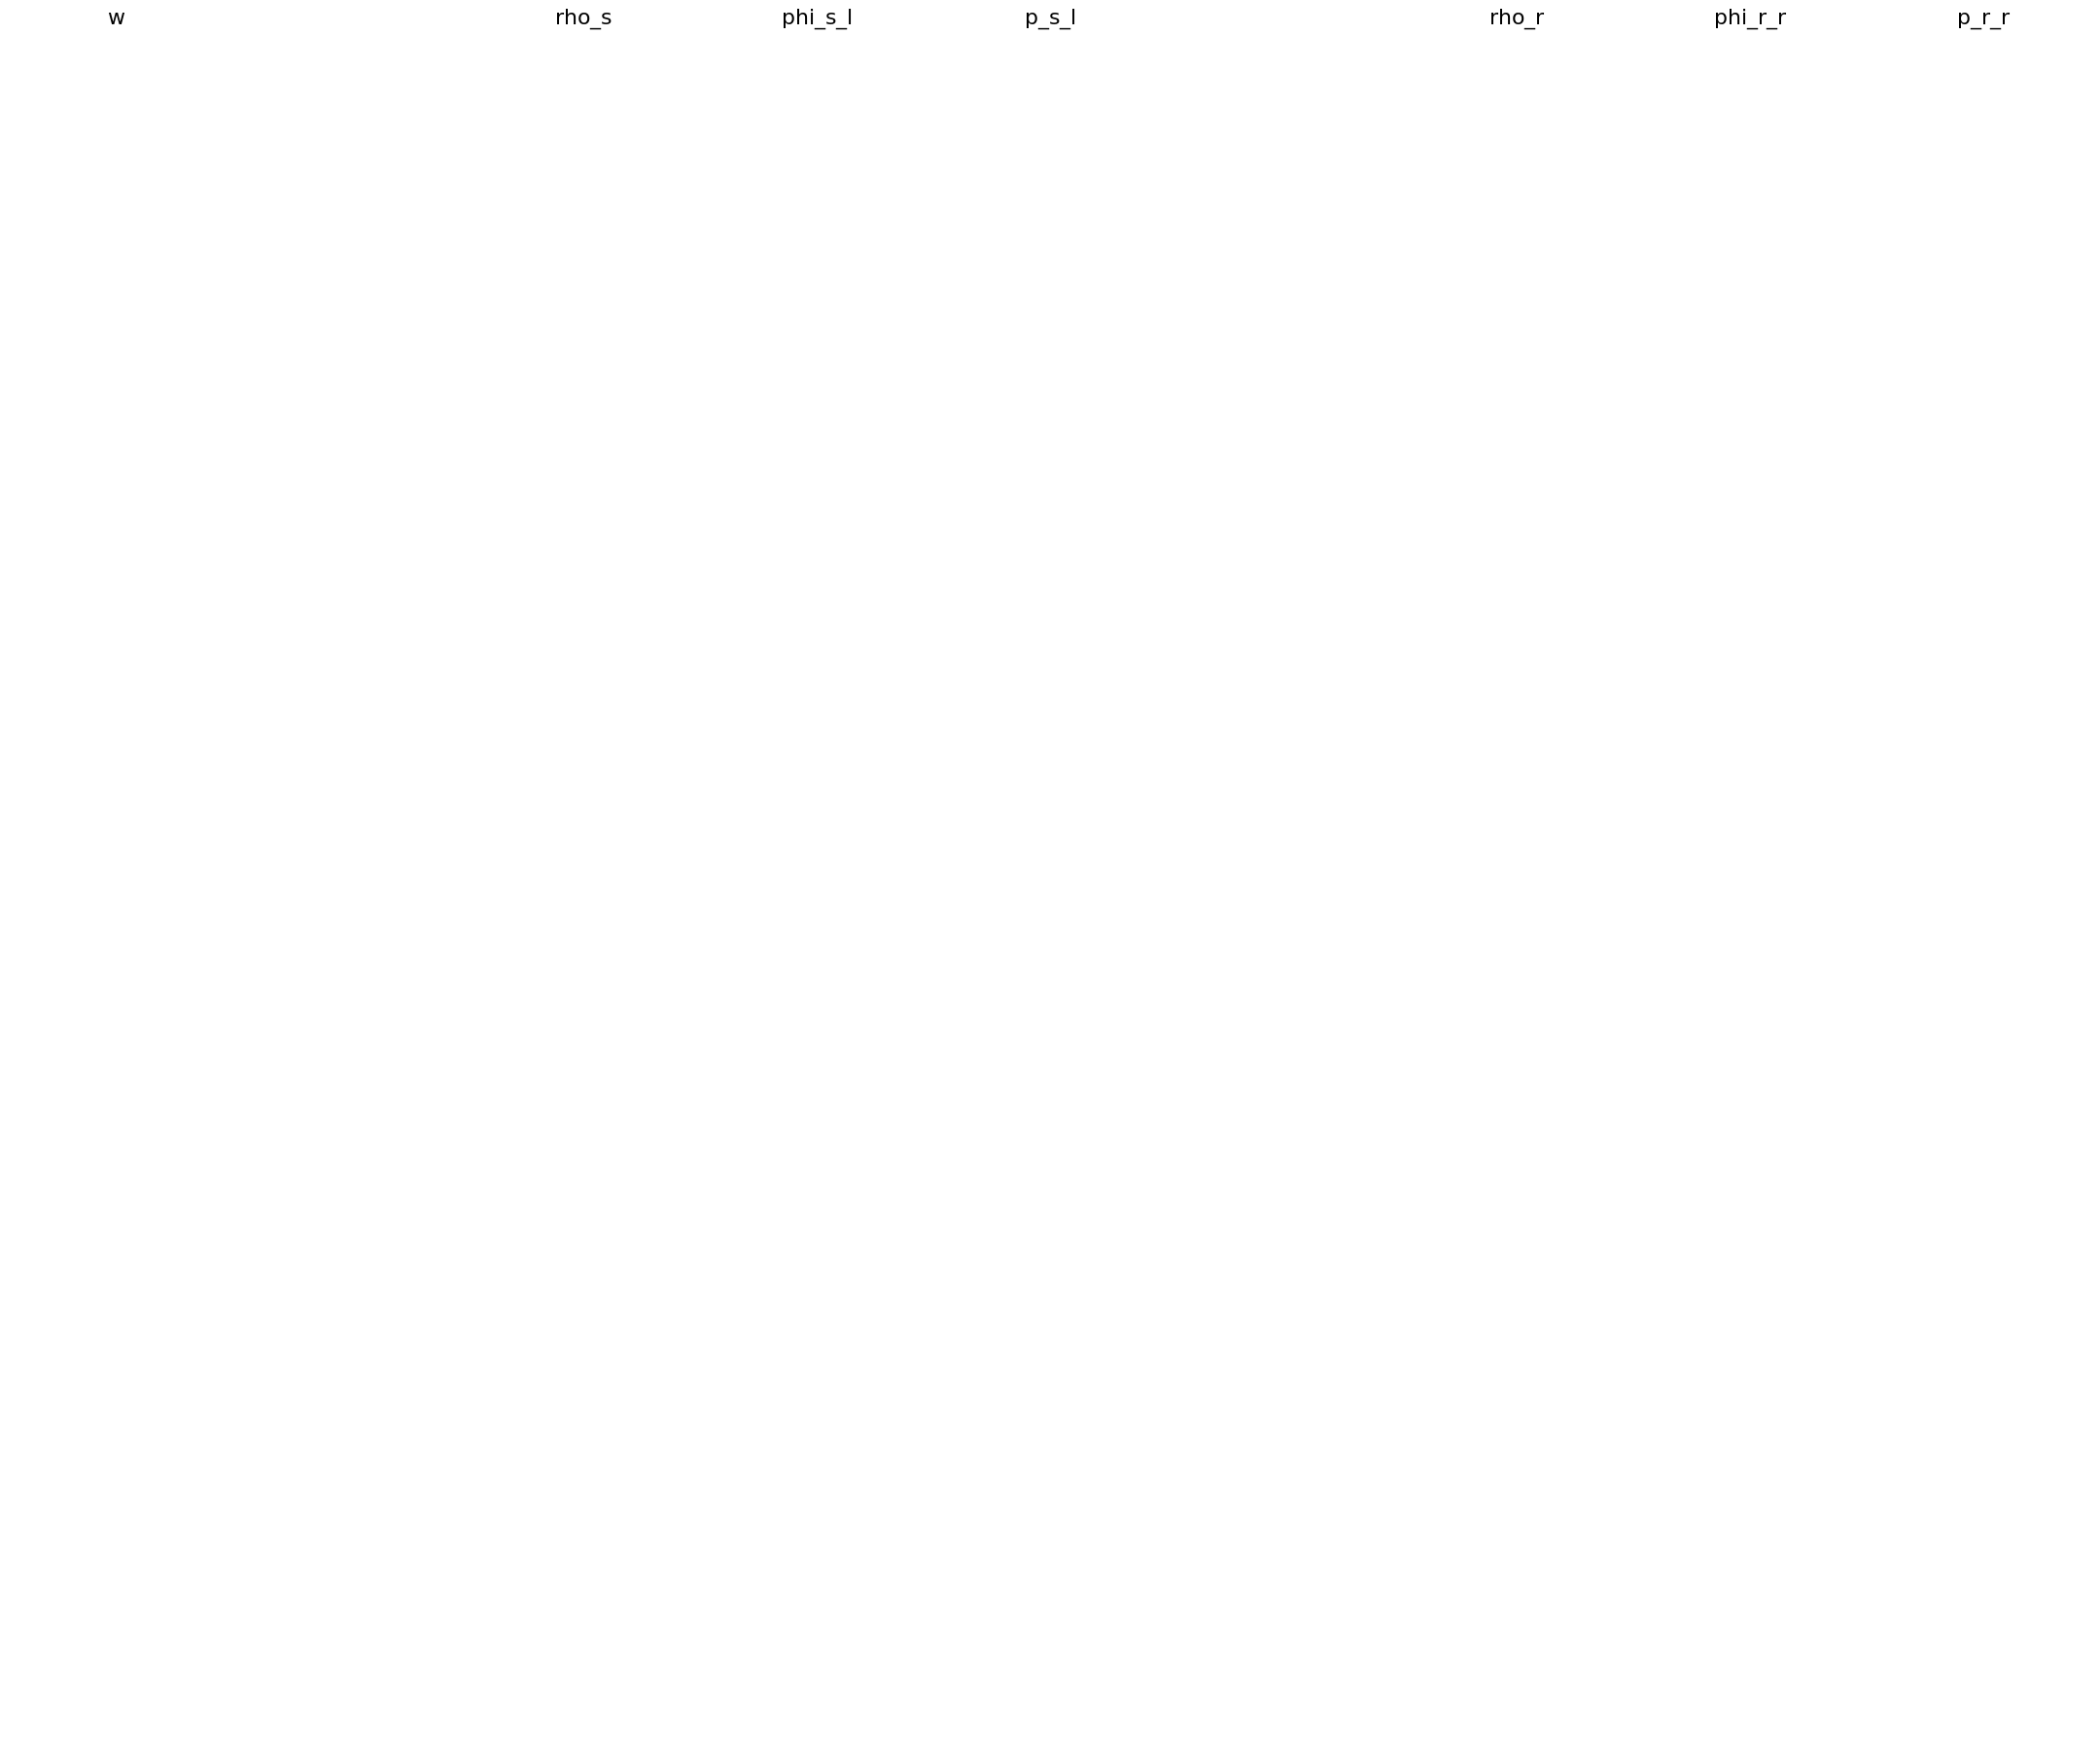

In [47]:
options(repr.plot.height = 15
       ,repr.plot.width = 18)
plot_all_forests(idx_of_interest
                ,my_anno_interactions = interactions$anno_interactions)

<span style="color:red">**ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!**</span>


ADD EXPLANATION OF WHAT WE SEE!!!!!!!!!!!!

### Heatmap number of differential interactions

[1] "Epithelial"
[1] "Epithelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Fibroblasts"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Endothelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Myeloid"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Mast"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "T-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Plasma"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "B-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[1] "Epithelial"
[1] "Epithelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Fibroblasts"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Endothelial"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Myeloid"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Mast"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "T-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "Plasma"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit Länge 0)
[1] 0
[1] "Epithelial"
[1] "B-cells"
[1] interaction_ID log2FC_weights sign          
<0 Zeilen> (oder row.names mit 

Warning message:
“The input is a data frame-like object, convert it to a matrix.”


[[1]]
png 
  2 

[[2]]
png 
  2

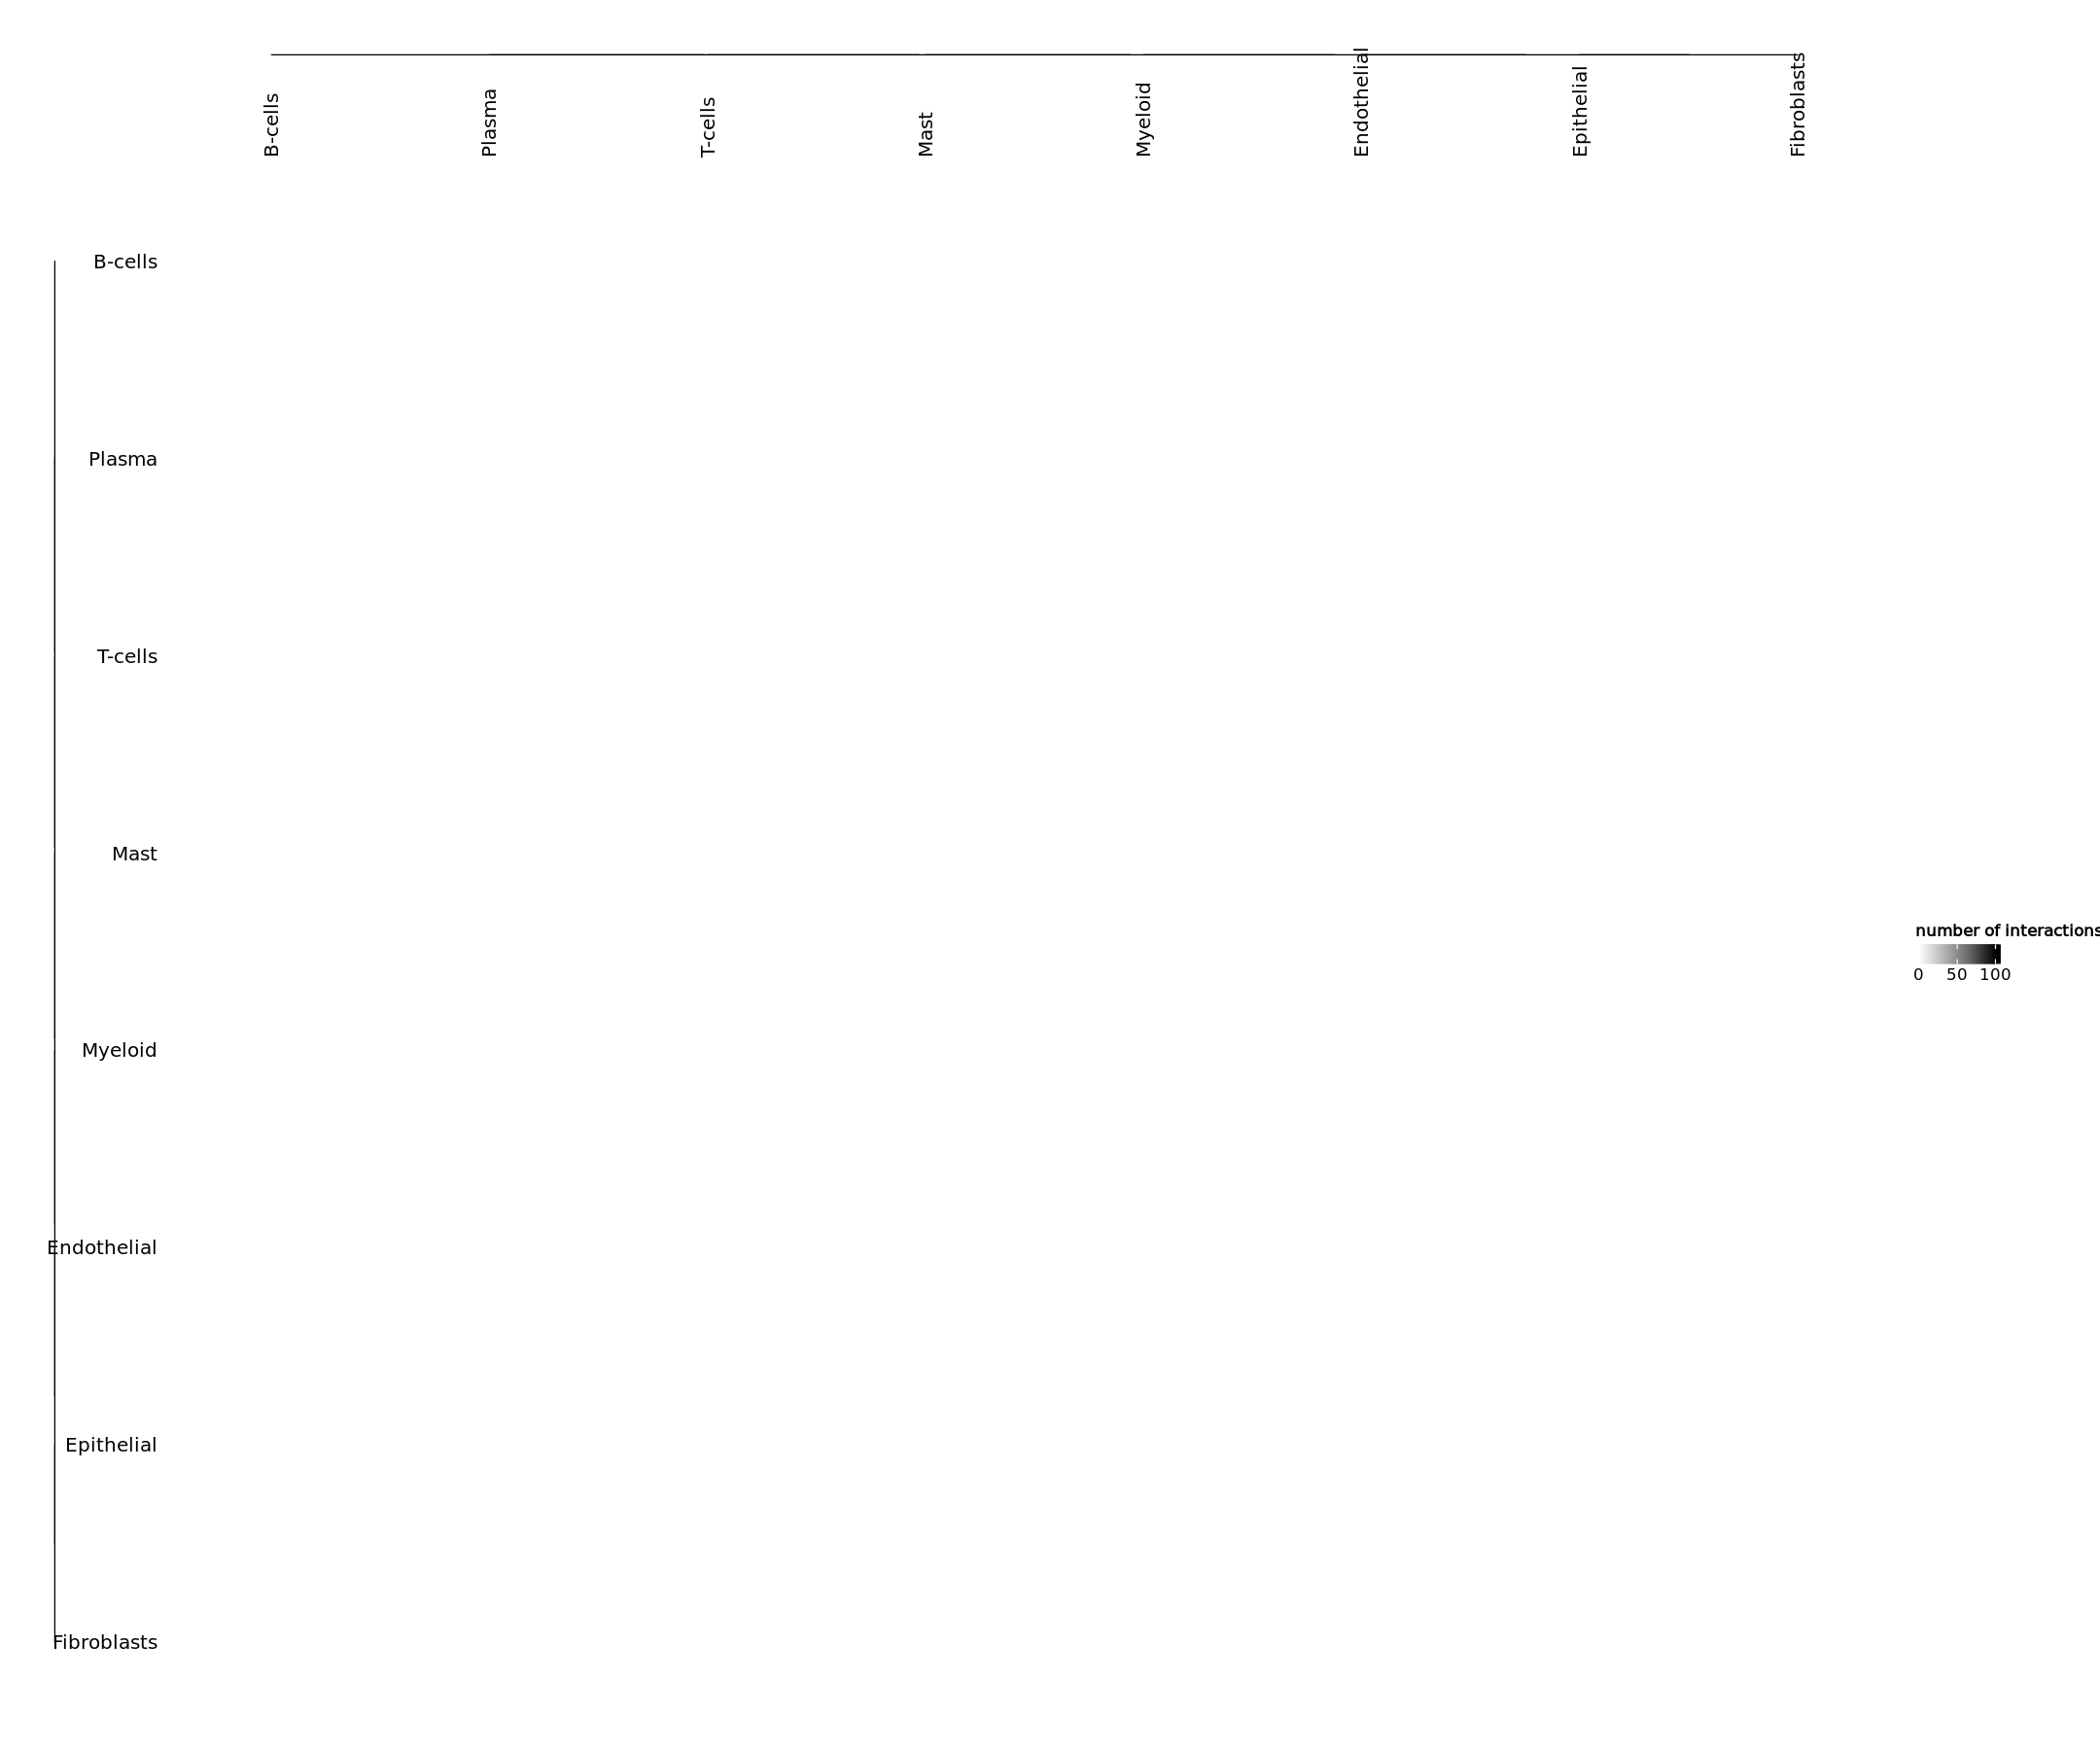

In [48]:
# mean number of interactions as heatmap
lapply(c("down"
         ,"up"
         #,"unchanged"
        )
       ,function(dir){
           # subset interactions
    ifelse(dir == "up"
              ,idx <- idx_good & idx_sign & idx_up
              ,ifelse(dir == "down"
                      ,idx <- idx_good & idx_sign & idx_down
                      ,idx <- !idx_sign & idx_good
                     )
              )
    
    # create a dummy data frame
    df <- as.data.frame(matrix(,nrow = length(cell_types)
                              ,ncol = length(cell_types)
                              )
                       )
    rownames(df) <- cell_types
    colnames(df) <- cell_types
    
    # populate the data frame
    for(send in cell_types){
        idx_send <- interactions$anno_interactions$sending_cell_type == send
        
        for(rec in cell_types){
            idx_rec <- interactions$anno_interactions$receiving_cell_type == rec
            
            print(send)
            print(rec)
            print(head(interactions$anno_interactions[idx & idx_send & idx_rec,c("interaction_ID","log2FC_weights", "sign")]))
            print(sum(idx & idx_send & idx_rec))
            
            df[send,rec] <- sum(idx & idx_send & idx_rec)
            
        }
    }
    
    print(df)
           
    my_color <-  colorRamp2(seq(0
                                ,100 #300
                                , length = 4)
                            , c("white","gray70","gray40","black"))
    
    h <- Heatmap(df
                 ,name = "number of interactions"
                 ,heatmap_legend_param = list(direction = "horizontal")
                 ,column_names_side = "top"
                 ,row_names_side = "left"
                 ,col = my_color
                )
           print(h
             #,heatmap_legend_side = "bottom"
                )
           
    pdf(file=paste0("figures/heatmap_cellTypes_number_"
                   ,dir
                   ,".pdf"))
          print(h
             #,heatmap_legend_side = "bottom"
               )
           dev.off()
    
       }
       )

# Export

In [49]:
print("save interactions_healthy_sub.RData")
save(interactions, file = "interactions_inflamed_non-inflamed_sub.RData")

[1] "save interactions_healthy_sub.RData"
